In [410]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import time
import shap
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from pandas_profiling import ProfileReport

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

In [3]:
df = pd.read_csv("weather_h.csv")

In [251]:
df.head()

,time,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,pressure,ozone,isocal,id_poi,hour,day,rain,date_time,year_month
0,1483225200,Overcast,cloudy,0.0,0.0,3.072222,0.161111,34.69,0.89,6.79,9.05,202.0,0.89,0.0,6.216,NaN,NaN,NaN,NaN,52-07T00,1,0,2017-01-01,0,2016-12-31 23:00:00,201612
1,1483228800,Mostly Cloudy,partly-cloudy-night,0.0,0.0,3.238889,0.561111,34.20,0.87,6.24,9.05,211.0,0.75,0.0,5.173,NaN,NaN,NaN,NaN,52-07T01,1,1,2017-01-01,0,2017-01-01 00:00:00,201701
2,1483232400,Mostly Cloudy,partly-cloudy-night,0.0,0.0,2.938889,-0.050000,32.87,0.84,6.94,10.44,210.0,0.75,0.0,4.830,NaN,NaN,NaN,NaN,52-07T02,1,2,2017-01-01,0,2017-01-01 01:00:00,201701
3,1483236000,Overcast,cloudy,0.0,0.0,2.738889,-0.366667,32.46,0.84,7.17,9.90,218.0,0.89,0.0,6.216,NaN,NaN,NaN,NaN,52-07T03,1,3,2017-01-01,0,2017-01-01 02:00:00,201701
4,1483239600,Overcast,cloudy,0.0,0.0,2.838889,-0.144444,32.62,0.84,6.86,7.66,216.0,0.89,0.0,6.216,NaN,NaN,NaN,NaN,52-07T04,1,4,2017-01-01,0,2017-01-01 03:00:00,201701


# EDA

### Timeline investigation

In [238]:
# convert time to datetime
df["date_time"] = pd.to_datetime(df['time'], unit='s')
df["year_month"] = df.date_time.dt.strftime("%Y%m")
df['month'] = df.date_time.dt.month

In [386]:
df.year_month.value_counts().sort_index()

201612      1
201701    744
201702    672
201703    744
201704    720
201705    744
201706    720
201707    744
201708    744
201709    720
201710    744
201711    720
201712    743
201808    288
201809    717
201810    744
201811    720
201812    743
Name: year_month, dtype: int64

so we have the whole year of 2017, one date from 2016, and august through december of 2018 as data months

## Target 

## Investigate rows where icon != "rain" but precipType = "rain" and vice versa

In [83]:
df.loc[((df.precipType == "rain")&(df.icon != "rain"))].head(10)

,time,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,pressure,ozone,isocal,id_poi,hour,day,rain
34,1483347600,Mostly Cloudy,partly-cloudy-day,0.0010,0.19,1.133333,-2.388889,33.10,0.96,7.40,9.61,272.0,0.75,0.0,2.093,rain,NaN,NaN,NaN,01-01T10,1,10,2017-01-02,0
35,1483351200,Mostly Cloudy,partly-cloudy-day,0.0003,0.19,1.650000,-1.516667,33.51,0.94,6.71,10.01,278.0,0.75,0.0,3.108,rain,NaN,NaN,NaN,01-01T11,1,11,2017-01-02,0
36,1483354800,Mostly Cloudy,partly-cloudy-day,0.0003,0.03,1.833333,-0.988889,33.55,0.93,5.93,8.15,289.0,0.75,0.0,3.730,rain,NaN,NaN,NaN,01-01T12,1,12,2017-01-02,0
37,1483358400,Mostly Cloudy,partly-cloudy-day,0.0014,0.25,2.394444,-0.333333,34.66,0.94,5.94,7.25,290.0,0.75,0.0,5.247,rain,NaN,NaN,NaN,01-01T13,1,13,2017-01-02,0
38,1483362000,Mostly Cloudy,partly-cloudy-day,0.0006,0.25,2.727778,-0.055556,34.31,0.90,6.24,9.08,282.0,0.75,0.0,6.216,rain,NaN,NaN,NaN,01-01T14,1,14,2017-01-02,0
53,1483416000,Overcast,cloudy,0.0015,0.03,1.677778,-2.055556,33.66,0.95,8.39,10.27,261.0,0.89,0.0,6.216,rain,NaN,NaN,NaN,01-02T05,1,5,2017-01-03,0
60,1483441200,Mostly Cloudy,partly-cloudy-day,0.0010,0.19,3.111111,-1.377778,35.39,0.92,12.81,18.28,250.0,0.75,0.0,6.216,rain,NaN,NaN,NaN,01-02T12,1,12,2017-01-03,0
65,1483459200,Mostly Cloudy,partly-cloudy-night,0.0015,0.29,3.461111,-1.377778,35.77,0.91,15.15,18.28,250.0,0.75,0.0,6.216,rain,NaN,NaN,NaN,01-02T17,1,17,2017-01-03,0
83,1483524000,Mostly Cloudy,partly-cloudy-day,0.0013,0.03,4.005556,-0.972222,33.57,0.80,16.93,30.28,260.0,0.61,0.0,6.216,rain,NaN,NaN,NaN,01-03T11,1,11,2017-01-04,0
85,1483531200,Mostly Cloudy,partly-cloudy-day,0.0002,0.03,3.922222,-0.316667,34.89,0.85,12.63,28.16,277.0,0.75,0.0,6.216,rain,NaN,NaN,NaN,01-03T13,1,13,2017-01-04,0


In [86]:
df.loc[((df.precipType != "rain")&(df.icon == "rain"))].head(10)

,time,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,pressure,ozone,isocal,id_poi,hour,day,rain


### Target Investigation conclusions:
icon is a subset of preciptype with regards to target information, we will use precipType == Rain as our target binary identifier

In [84]:
df["rain"] = (df.precipType == "rain").astype("int")

In [85]:
df.rain.value_counts()

0    9036
1    2936
Name: rain, dtype: int64

This is an imbalanced classifier and we need to account for that when predicting the target. 

## Feature Correlations, outliers, missing values, and interactions

In [249]:
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

In [250]:
profile.to_widgets()


## Continuous Variable Analysis

In [164]:
def univariate_swarm_boxplot(df, feat1, feat2):
    plt.figure(figsize = (12,8))
    sns.boxplot(x=df[feat1], y=df[feat2], palette = "viridis")
    ax = sns.violinplot(x=df[feat1], y=df[feat2], color="turquoise")
    plt.setp(ax.collections, alpha=.3)
    plt.show()

In [457]:
def univariate_cdplot(df, feat1, feat2):
    plt.figure(figsize = (12,8))
    sns.kdeplot(data = df, x = feat2, hue = feat1,
                palette= "viridis_r", multiple = "fill")
    plt.legend(["Rain","Not Rain"])
    plt.show()

In [131]:
continuous_cols = ['precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility', 'pressure', 'ozone', 'hour']

Pearson correlation of precipIntensity to target rain: 0.4183570202189038


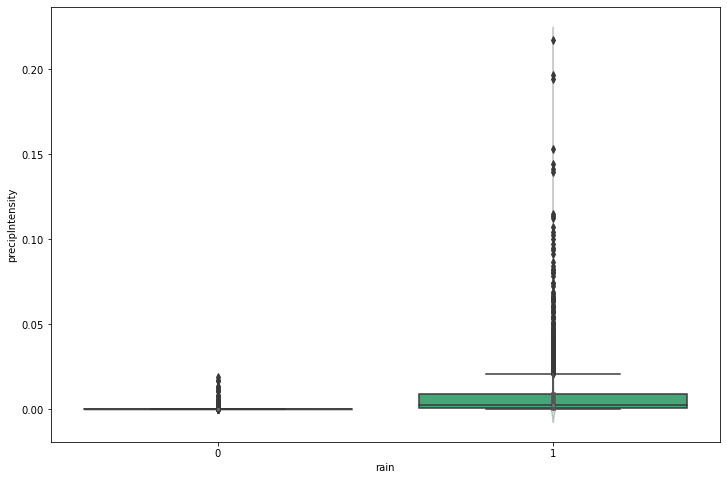

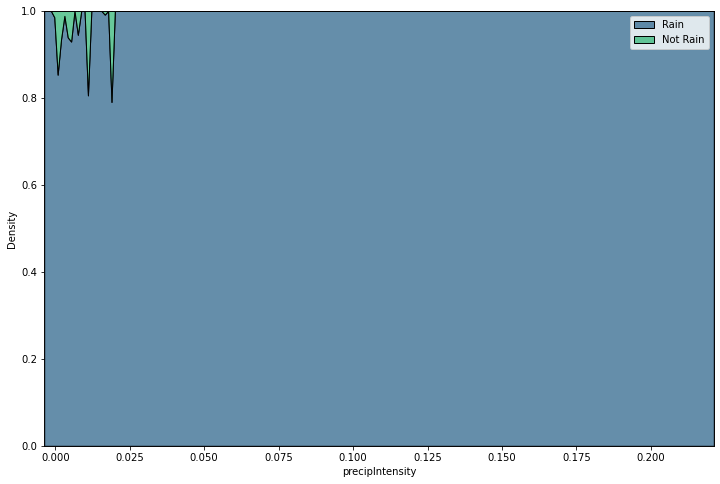

Pearson correlation of precipProbability to target rain: 0.744839672085447


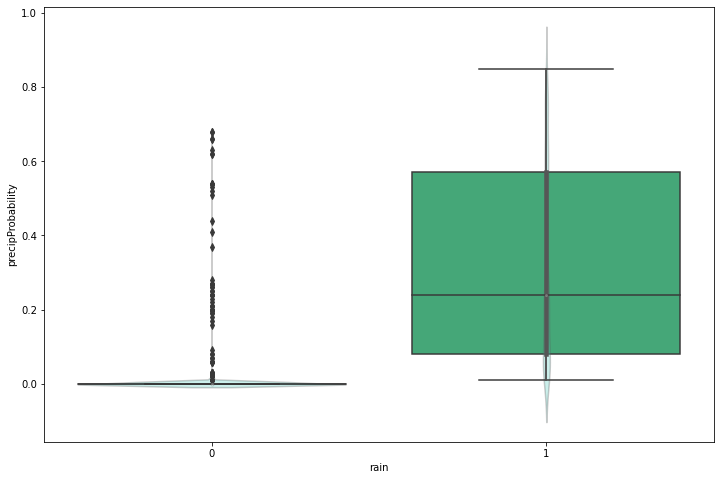

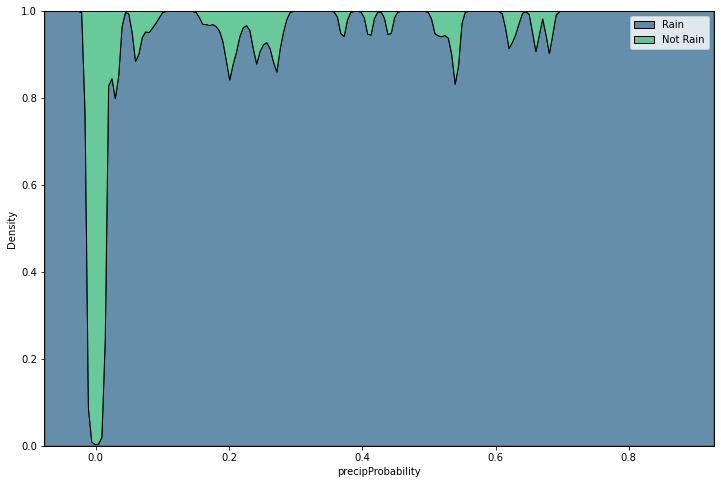

Pearson correlation of temperature to target rain: 0.08016902640272865


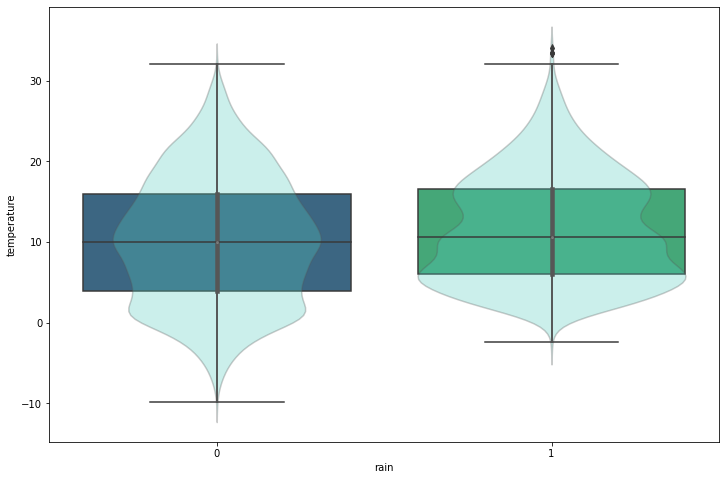

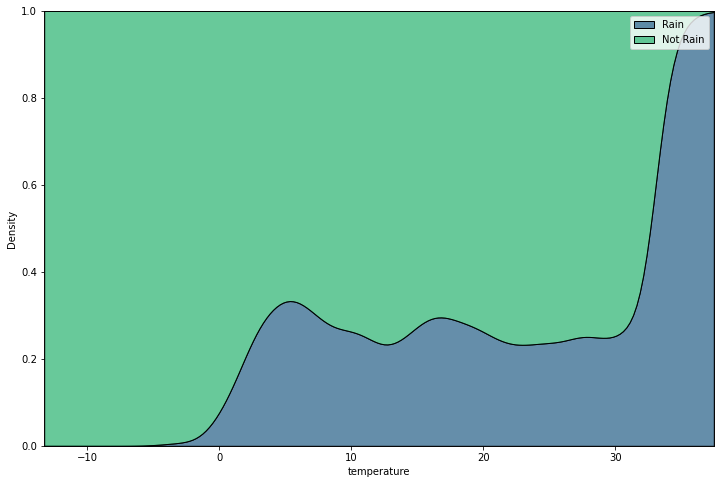

Pearson correlation of apparentTemperature to target rain: 0.057075963123269104


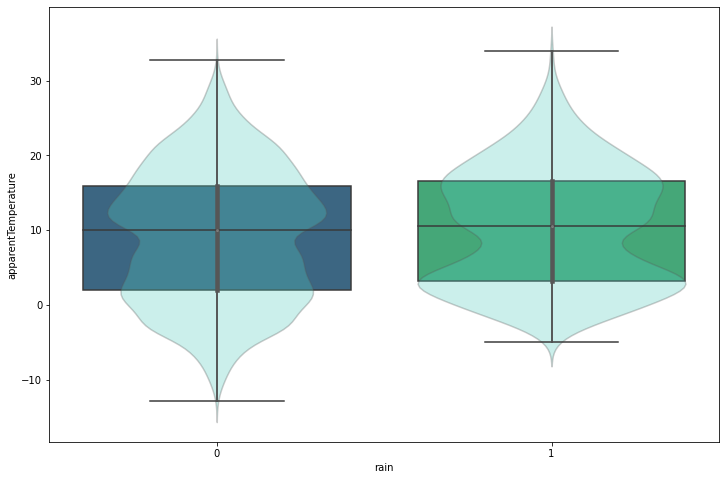

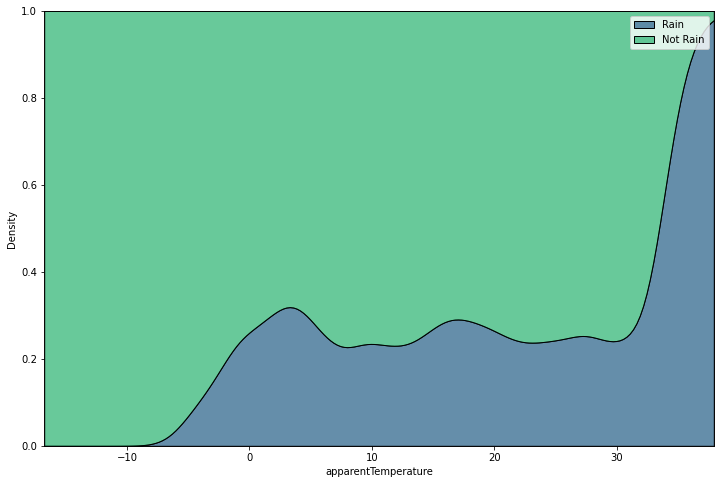

Pearson correlation of dewPoint to target rain: 0.13632094599195582


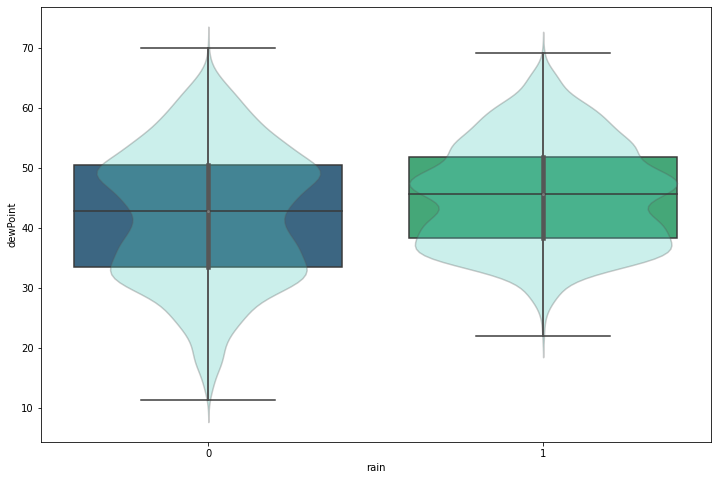

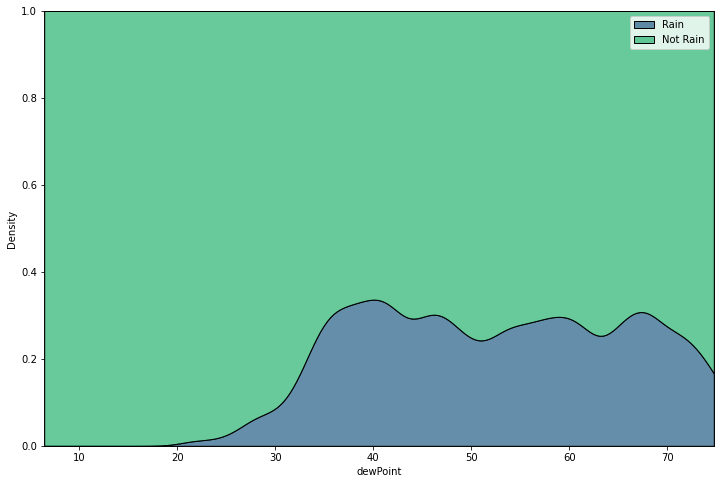

Pearson correlation of humidity to target rain: 0.08380060467019579


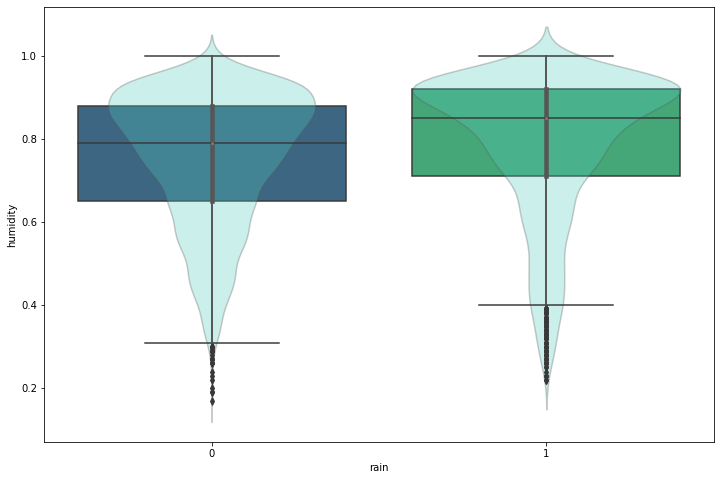

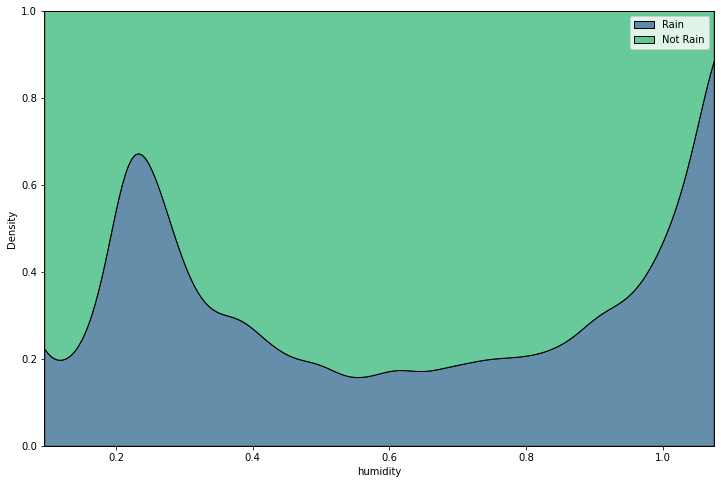

Pearson correlation of windSpeed to target rain: 0.33303190010293954


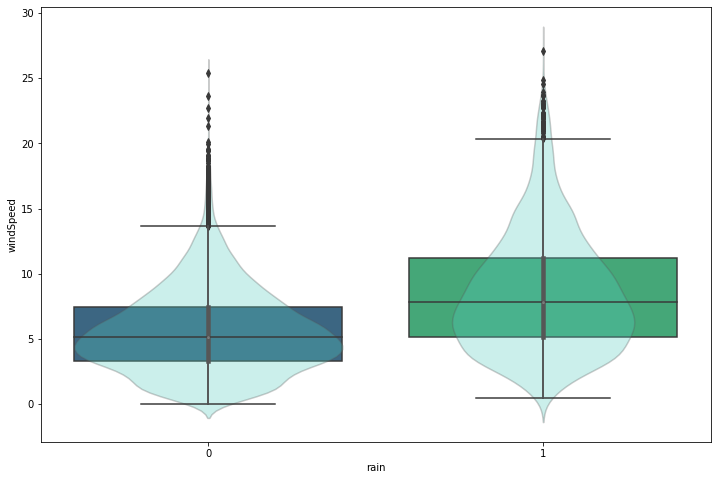

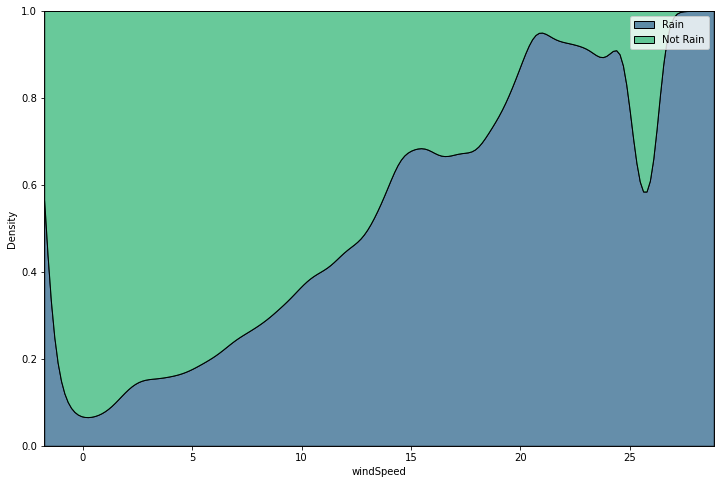

Pearson correlation of windGust to target rain: 0.3640423278666347


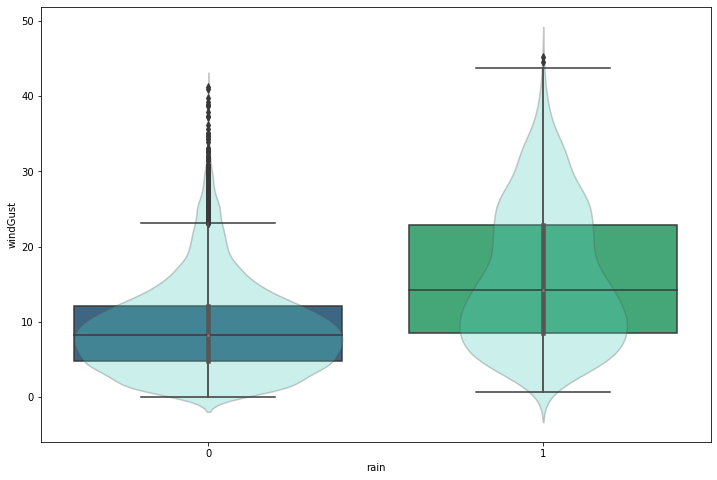

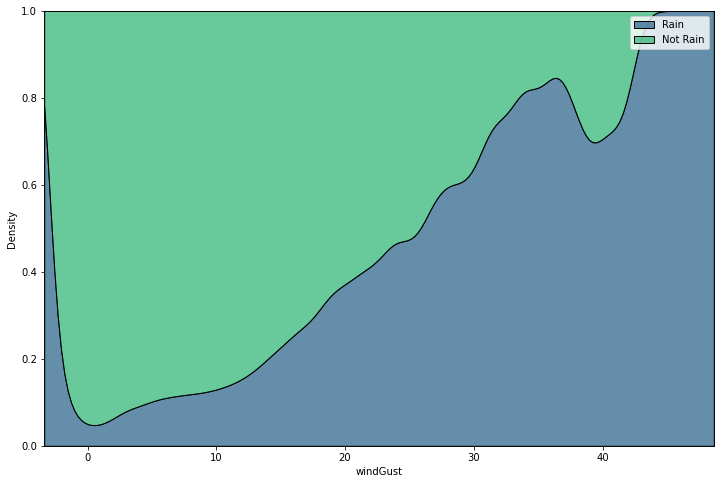

Pearson correlation of windBearing to target rain: 0.07319834457971752


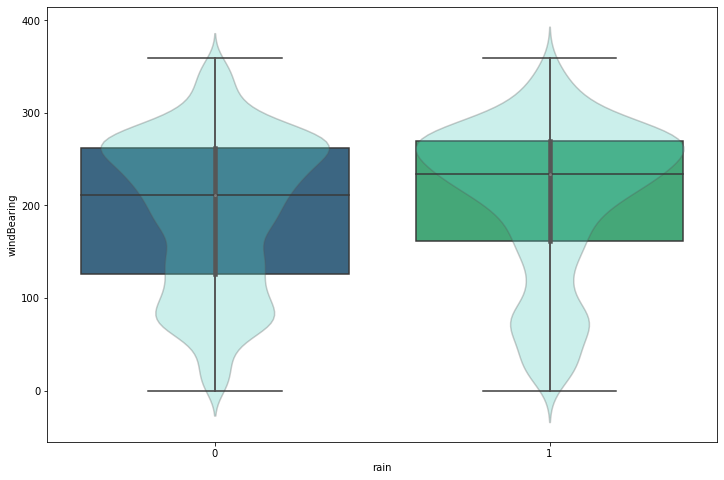

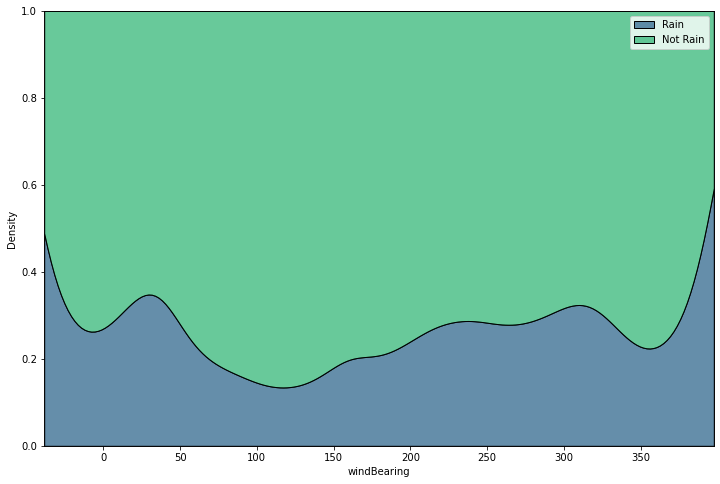

Pearson correlation of cloudCover to target rain: 0.20163919729637123


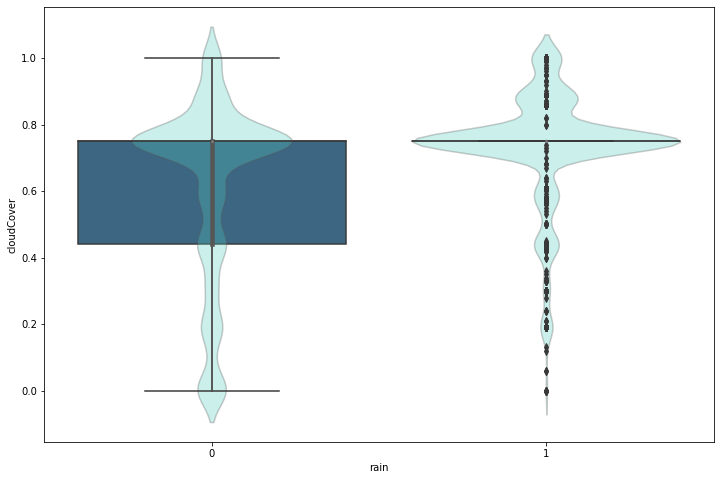

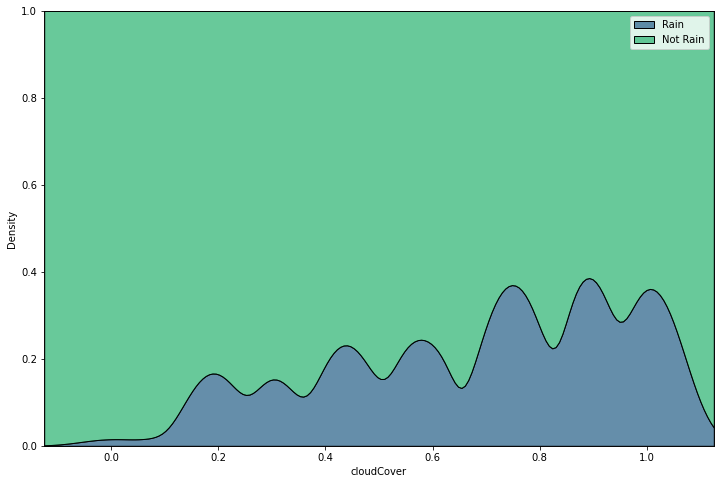

Pearson correlation of uvIndex to target rain: -0.01763781579378614


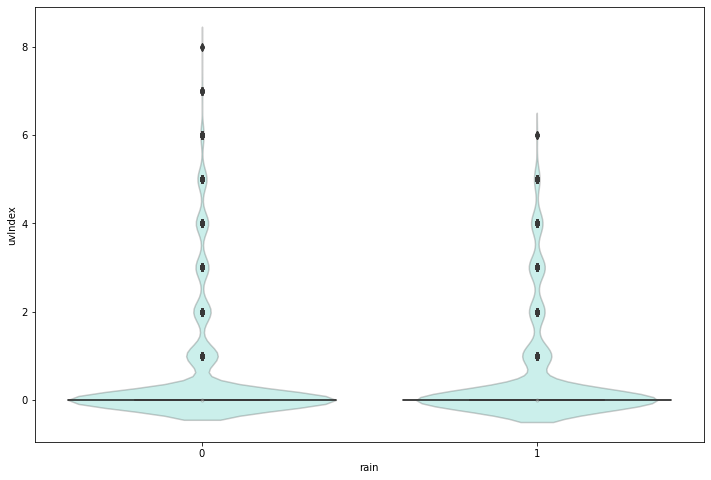

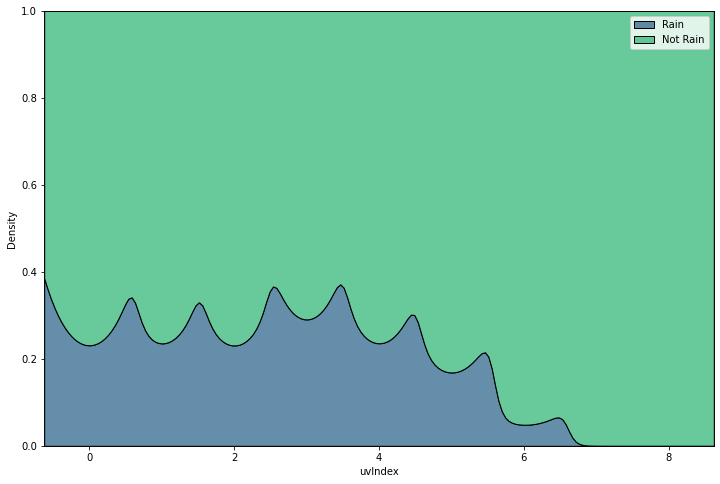

Pearson correlation of visibility to target rain: -0.05603656117796912


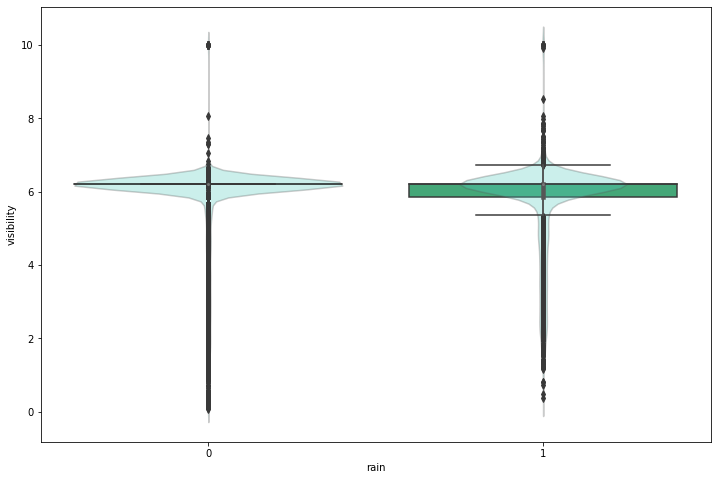

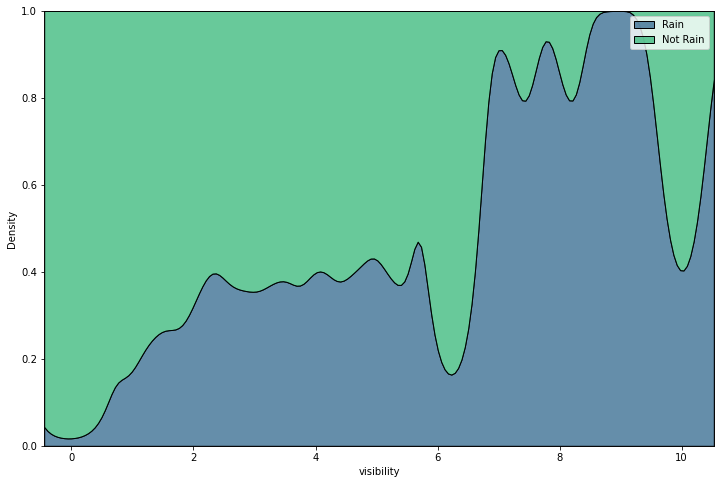

Pearson correlation of pressure to target rain: -0.32128038860713626


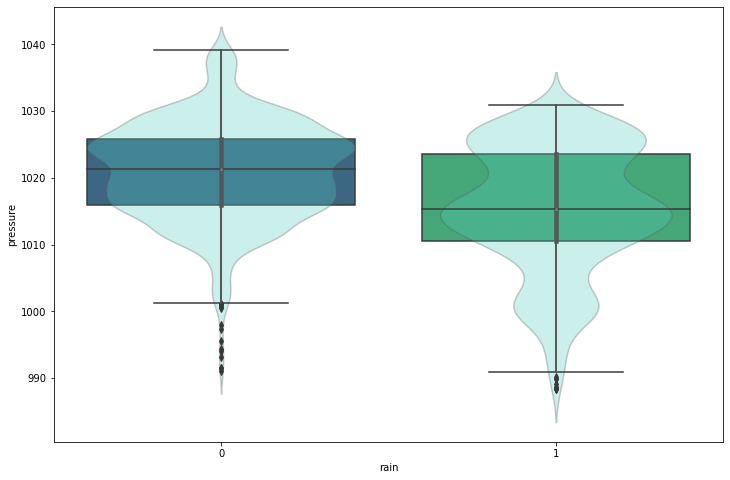

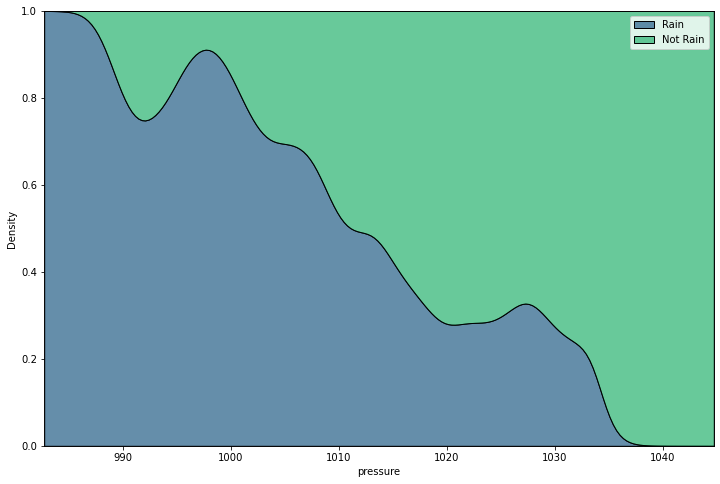

Pearson correlation of ozone to target rain: 0.16530950578304193


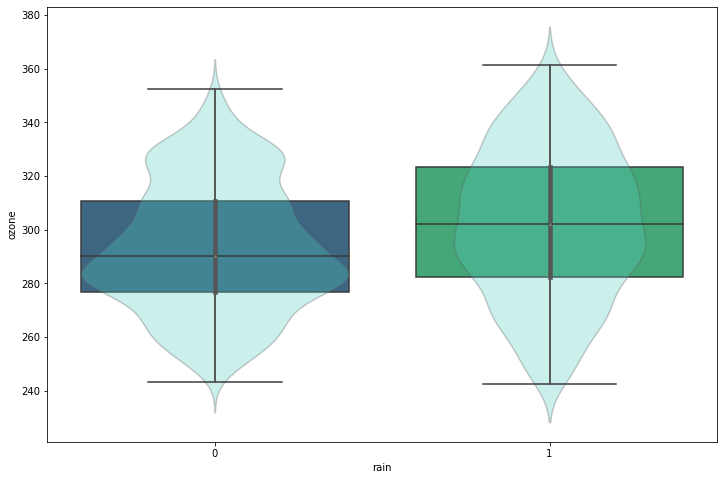

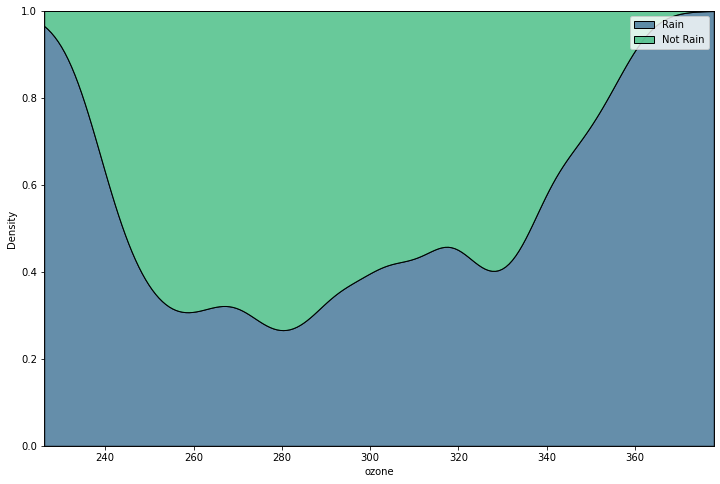

Pearson correlation of hour to target rain: 0.023323025239919724


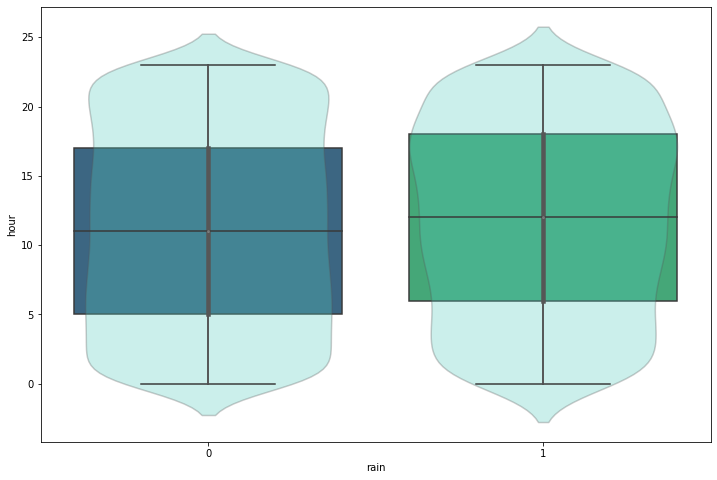

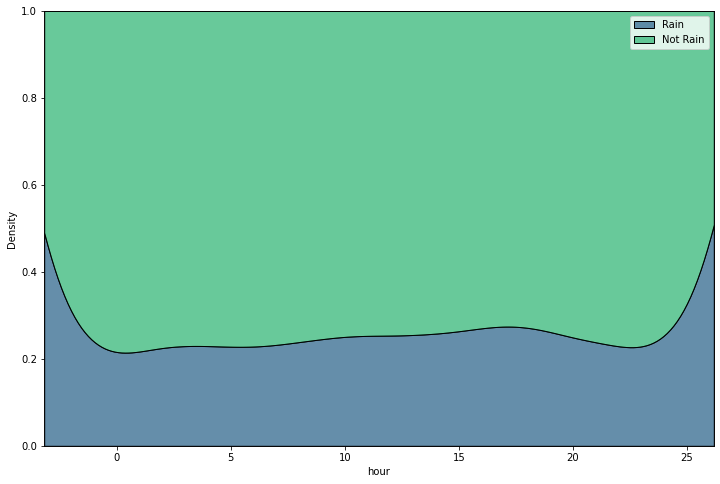

In [458]:
for col in continuous_cols:
    print("Pearson correlation of {} to target rain: {}".format(col, df[col].corr(df.rain)))
    univariate_swarm_boxplot(df, 'rain', col)
    univariate_cdplot(df, 'rain', col)

I personally beleive that precipIntensity and especially precipProbability are target leakage given the target is the event of rain 

#### looking at rain over time

In [221]:
#source: https://stackoverflow.com/questions/32485907/matplotlib-and-numpy-create-a-calendar-heatmap
def date_heatmap(series, start=None, end=None, mean=False, ax=None, **kwargs):
    '''Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    '''
    DAYS = ['Sun.', 'Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.']
    MONTHS = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']
    # Combine values occurring on the same day.
    dates = series.index.floor('D')
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, 'D')

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, 'D')

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks.
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax

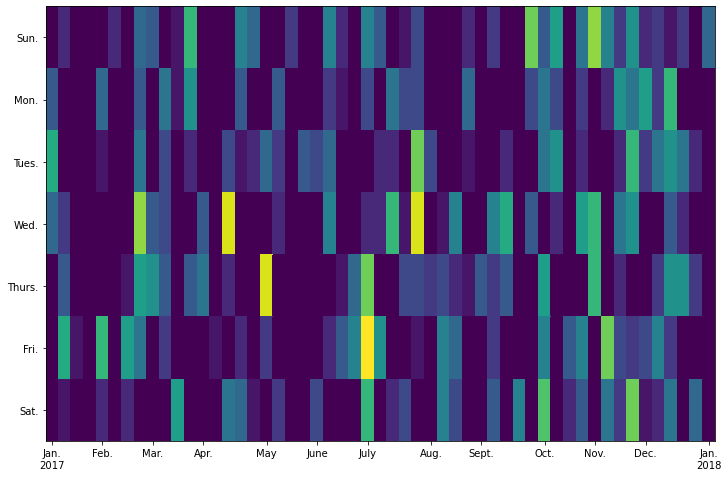

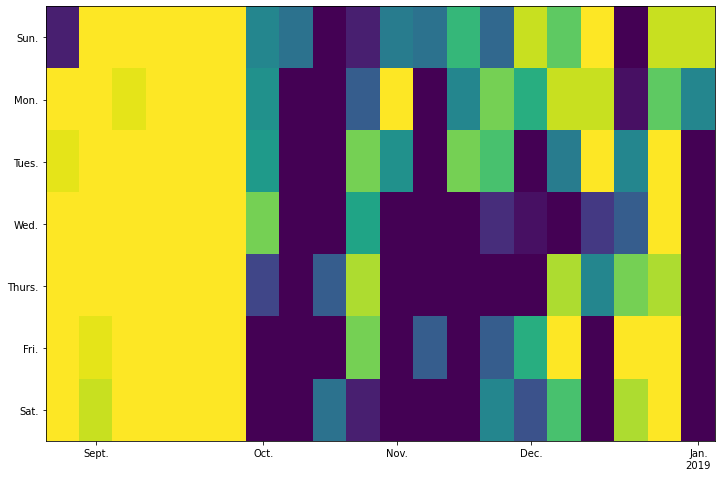

In [231]:
# visualizing rain over time
rain_cal = df[["date_time","rain"]].set_index("date_time")['rain']
for year in [2017,2018]:
    plt.figure(figsize = (12,8))
    date_heatmap(rain_cal.loc['{}-01-01'.format(year):'{}-12-31'.format(year)])
    plt.show()

# feature creation ideas
- rolling average of rain prior
- increasing or decreasing prior precipitation and precipprobabality (rolling increasing or rolling decreasing)
- maybe do the same for prior pressure and prior ozone, as well as any other features of interest

#### Rolling average of rain prior

In [273]:
if ("raining_last_hour" in df.columns.values):
    df.drop(columns = "raining_last_hour", inplace = True)
shifted_rain = df[['date_time','rain']].set_index('date_time').shift(freq= DateOffset(hours=1)).reset_index()
shifted_rain.rename(columns = {"rain":"raining_last_hour"}, inplace = True)
df = df.merge(right = shifted_rain,  on = "date_time", how = "left")

In [288]:
# there are 7 instances of the dataframe not having a prior hour to see if if was raining the hour prior. 
# will leave as NA for now 
df.loc[df.raining_last_hour.isnull()]

,time,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType,precipAccumulation,pressure,ozone,isocal,id_poi,hour,day,rain,date_time,year_month,raining_last_hour
0,1483225200,Overcast,cloudy,0.0,0.0,3.072222,0.161111,34.69,0.89,6.79,9.05,202.0,0.89,0.0,6.216,NaN,NaN,NaN,NaN,52-07T00,1,0,2017-01-01,0,2016-12-31 23:00:00,201612,NaN
8760,1534716000,Clear,clear-night,NaN,NaN,20.000000,20.000000,53.59,0.60,1.11,NaN,90.0,NaN,0.0,6.216,rain,NaN,NaN,NaN,34-01T00,1,0,2018-08-20,1,2018-08-19 22:00:00,201808,NaN
8793,1534838400,Partly Cloudy,partly-cloudy-day,NaN,NaN,18.438889,18.438889,51.00,0.60,6.80,NaN,300.0,0.19,3.0,6.216,rain,NaN,NaN,NaN,34-02T10,1,10,2018-08-21,1,2018-08-21 08:00:00,201808,NaN
9034,1535709600,Mostly Cloudy,partly-cloudy-day,NaN,NaN,15.994444,15.994444,52.80,0.75,8.69,NaN,264.0,0.75,4.0,6.216,rain,NaN,NaN,NaN,35-05T12,1,12,2018-08-31,1,2018-08-31 10:00:00,201808,NaN
9065,1535824800,Mostly Cloudy,partly-cloudy-night,NaN,NaN,20.122222,20.122222,47.42,0.47,5.18,NaN,110.0,0.75,0.0,6.216,rain,NaN,NaN,NaN,35-06T20,1,20,2018-09-01,1,2018-09-01 18:00:00,201809,NaN
9068,1535839200,Mostly Cloudy,partly-cloudy-night,NaN,NaN,16.683333,16.683333,49.99,0.65,2.24,NaN,30.0,0.75,0.0,6.216,rain,NaN,NaN,NaN,35-07T00,1,0,2018-09-02,1,2018-09-01 22:00:00,201809,NaN
9109,1535990400,Clear,clear-day,NaN,NaN,28.005556,28.005556,52.58,0.36,11.73,NaN,71.0,NaN,NaN,6.216,rain,NaN,NaN,NaN,36-01T18,1,18,2018-09-03,1,2018-09-03 16:00:00,201809,NaN


In [305]:
print("Pearson correlation of raining_last_hour to target rain: {}".format(df.raining_last_hour.corr(df.rain)))
raining_table = pd.DataFrame( {"count" : df.groupby(["rain"]).raining_last_hour.value_counts(),
               "pct": df.groupby(["rain"]).raining_last_hour.value_counts() / df.groupby(["rain"]).raining_last_hour.count()})
raining_table

Pearson correlation of raining_last_hour to target rain: 0.8305083945445377


count       pct
rain raining_last_hour                 
0    0.0                 8660  0.958495
     1.0                  375  0.041505
1    1.0                 2555  0.872014
     0.0                  375  0.127986

We see that 87% of the time that when it is raining, it was raining in the hour prior.
We also see that in ~96% of the time when it is not raining, it was not raining in the hour prior. 

#### rolling increasing or decreasing values of several variables
check ['precipIntensity', 'precipProbability','temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'windGust', 'visibility',  'precipType', 'precipAccumulation', 'pressure' , 'ozone']

In [368]:
rolling_vars =  ['precipIntensity', 'precipProbability','temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'windGust', 'visibility', 'pressure' , 'ozone']

In [425]:
# source https://stackoverflow.com/questions/42138357/pandas-rolling-slope-calculation
def calc_slope(x):
    try:
        slope = np.polyfit(range(len(x)), x, 1)[0]
    except:
        slope = np.NaN
    return slope

print("starting rolling feature slope creation...")
start = time.time()
for col in rolling_vars:
    # set condition for not using current probability of precipitation in rolling slope calculation
    if (col in ['precipProbability','precipIntensity']):
        closed = "left"
    else:
        closed = None
    df["3_hr_{}_slope".format(col)] = df[['date_time',col]].set_index('date_time')\
                                        .rolling('3h', min_periods=2, closed = closed)\
                                        .apply(calc_slope).reset_index(drop = True)
    df["6_hr_{}_slope".format(col)] = df[['date_time',col]].set_index('date_time')\
                                        .rolling('6h', min_periods=2, closed = closed)\
                                        .apply(calc_slope).reset_index(drop = True)
    df["12_hr_{}_slope".format(col)] = df[['date_time',col]].set_index('date_time')\
                                        .rolling('12h', min_periods=2, closed = closed)\
                                        .apply(calc_slope).reset_index(drop = True)

elapsed_time_fl = (time.time() - start) 
print("Finished, took {} seconds.".format(elapsed_time_fl))

starting rolling feature slope creation...
Finished, took 69.61023473739624 seconds.


After investigation the correlations between 3, 6, and 12 hour rolling features and the target as well as their correlations to each other, I have decided to drop the 6 hour since it was highly correlated to both the 3 and 12, and am keeping the other 2 

Pearson correlation of 3_hr_precipIntensity_slope to target rain: 0.11092537182618088


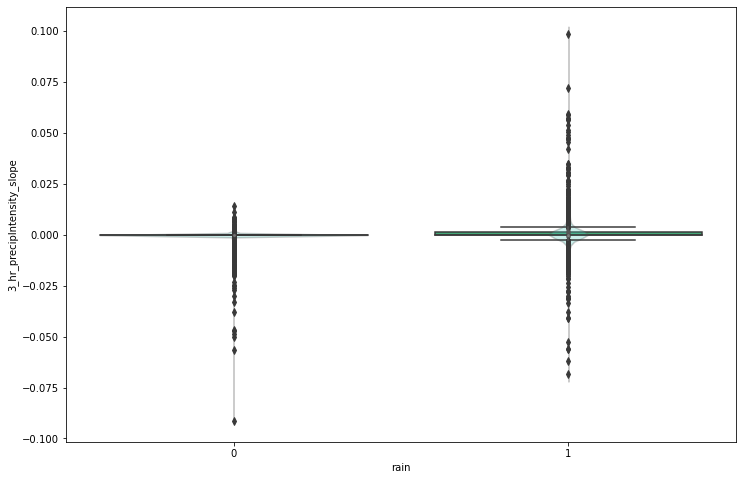

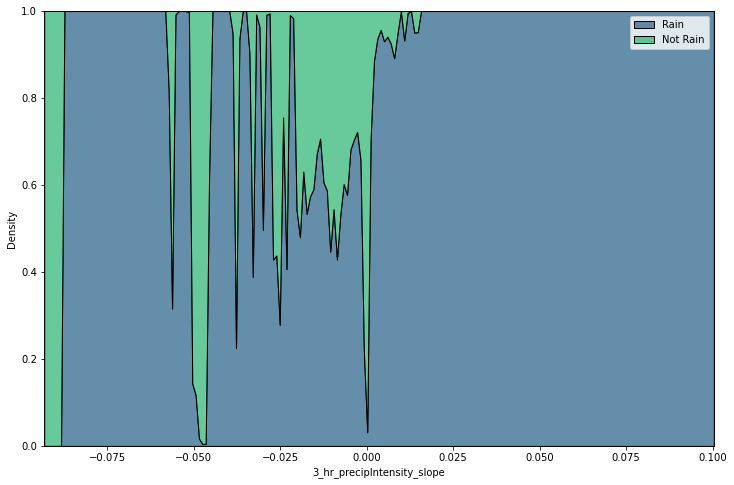

Pearson correlation of 12_hr_precipIntensity_slope to target rain: 0.19514968506876018


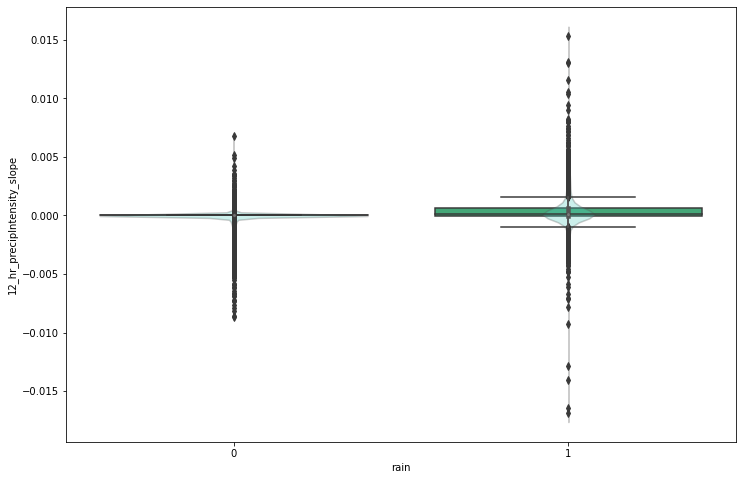

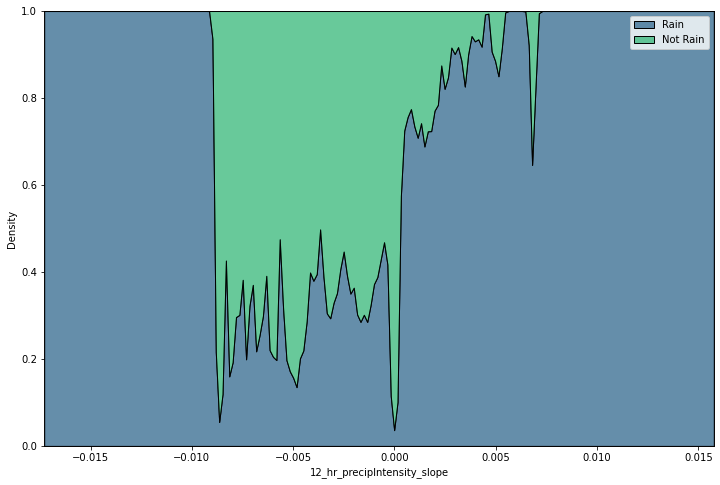

Pearson correlation of 3_hr_precipProbability_slope to target rain: 0.22782178290855243


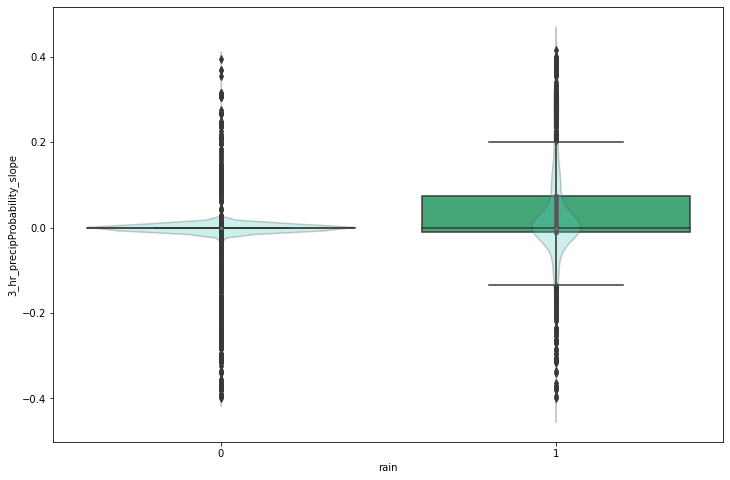

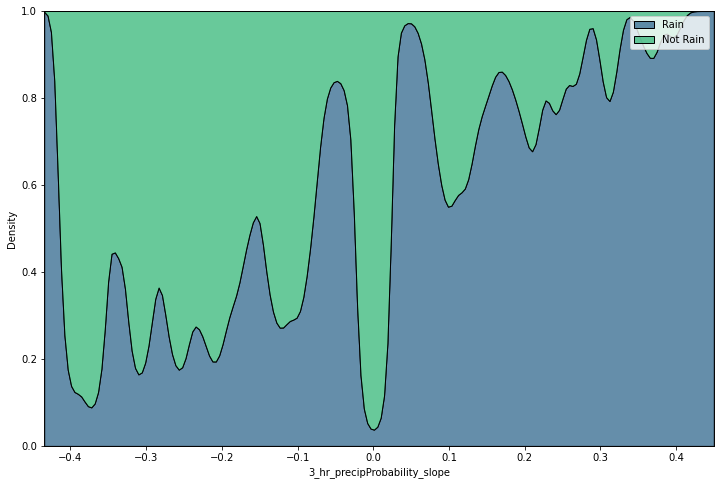

Pearson correlation of 12_hr_precipProbability_slope to target rain: 0.29675181896302594


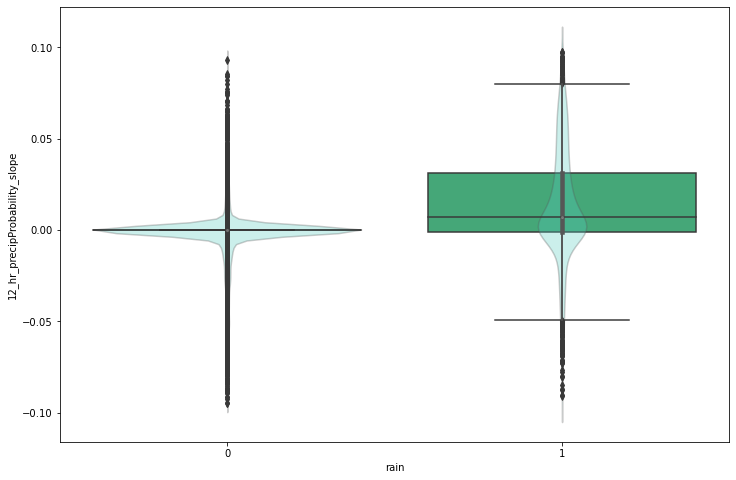

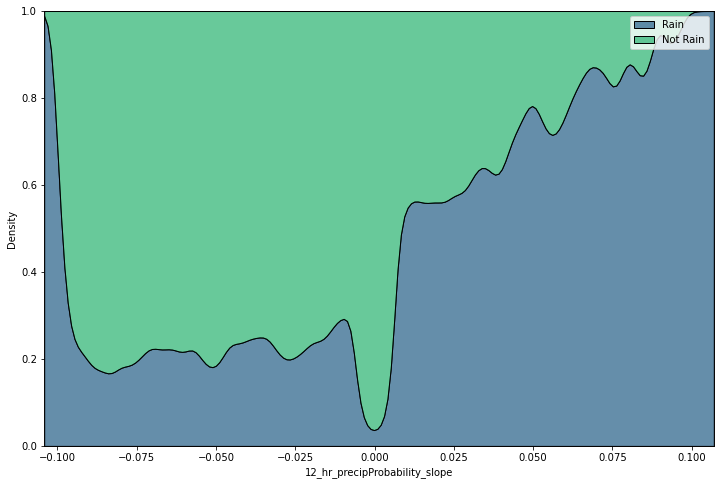

Pearson correlation of 3_hr_temperature_slope to target rain: -0.03726492376259472


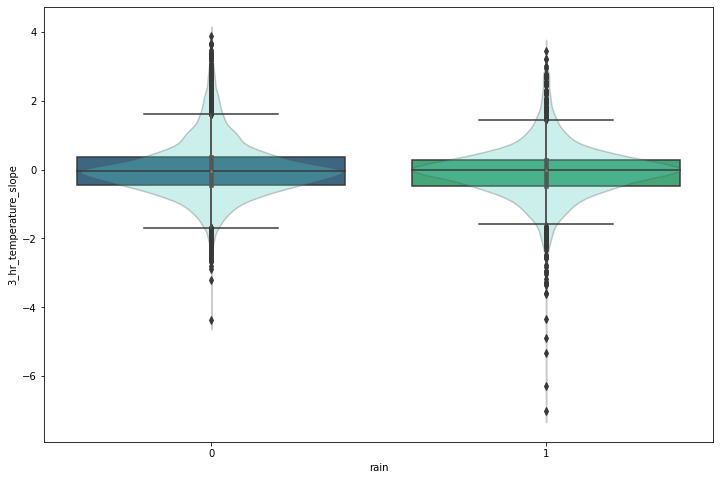

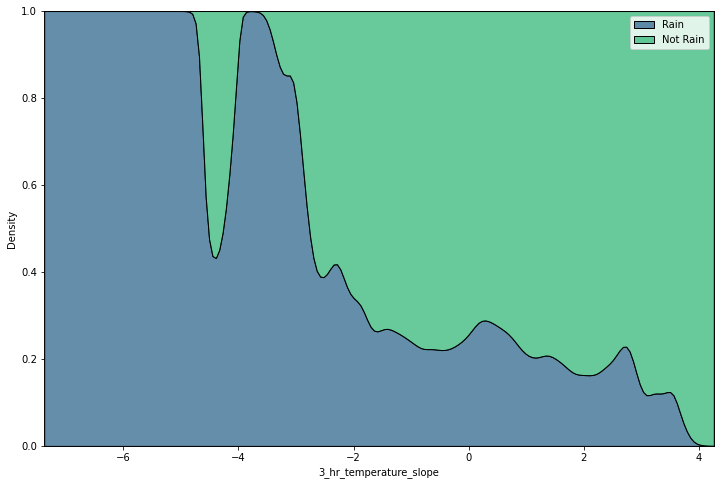

Pearson correlation of 12_hr_temperature_slope to target rain: 0.01745978788229824


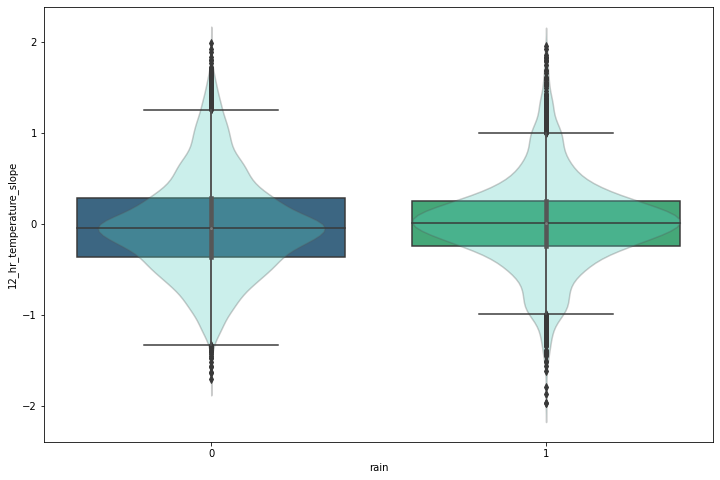

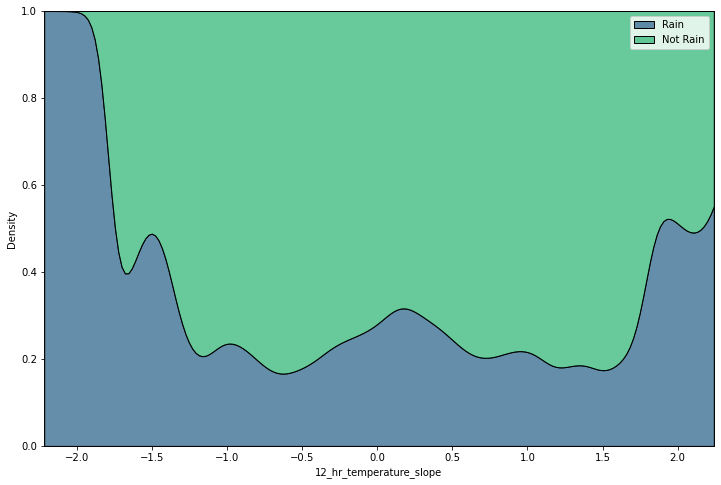

Pearson correlation of 3_hr_apparentTemperature_slope to target rain: -0.03733889778790573


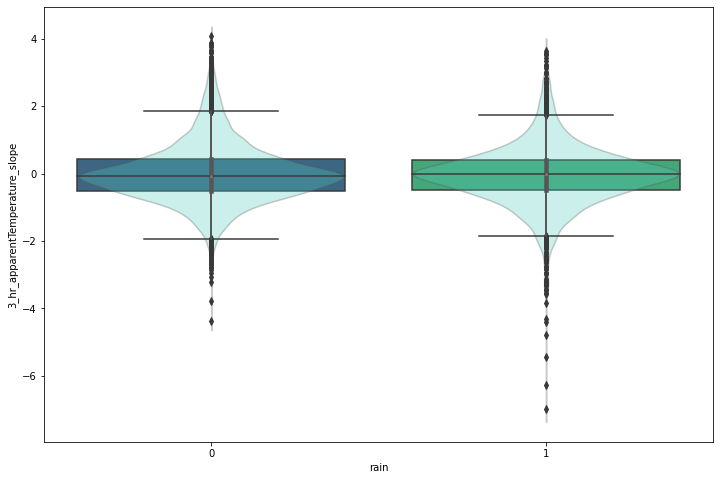

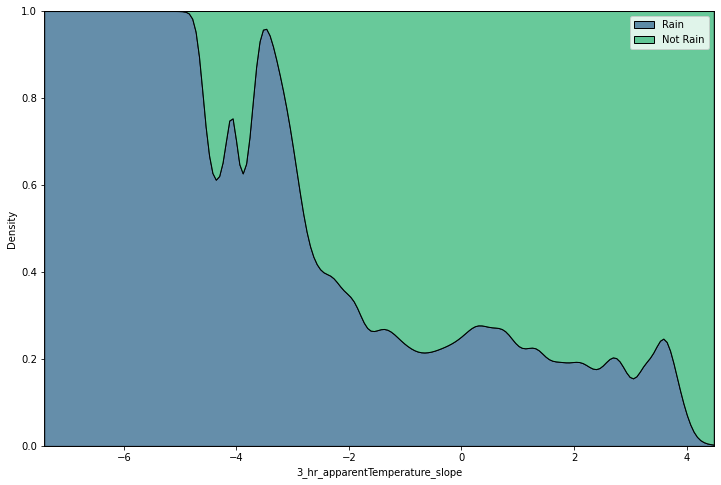

Pearson correlation of 12_hr_apparentTemperature_slope to target rain: 0.015291845474589132


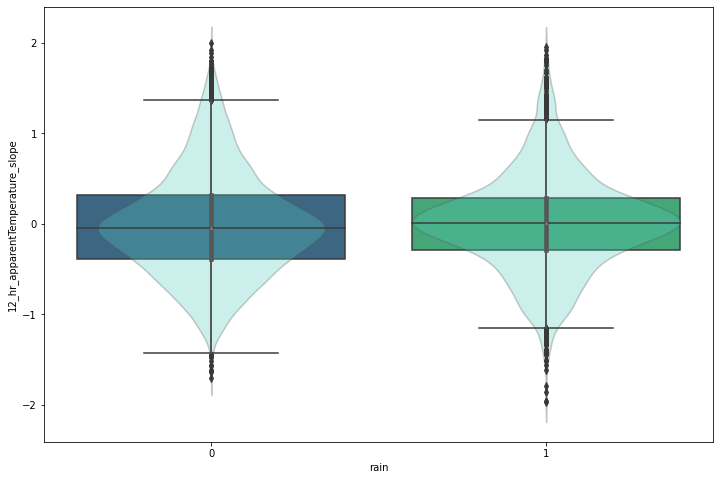

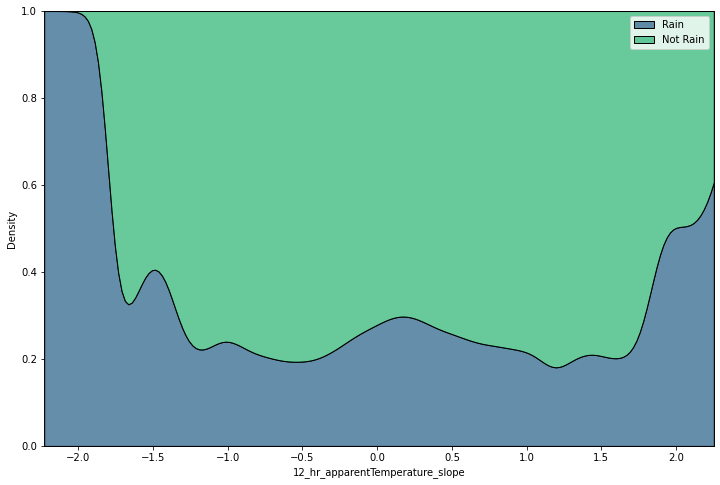

Pearson correlation of 3_hr_dewPoint_slope to target rain: 0.08812106272657834


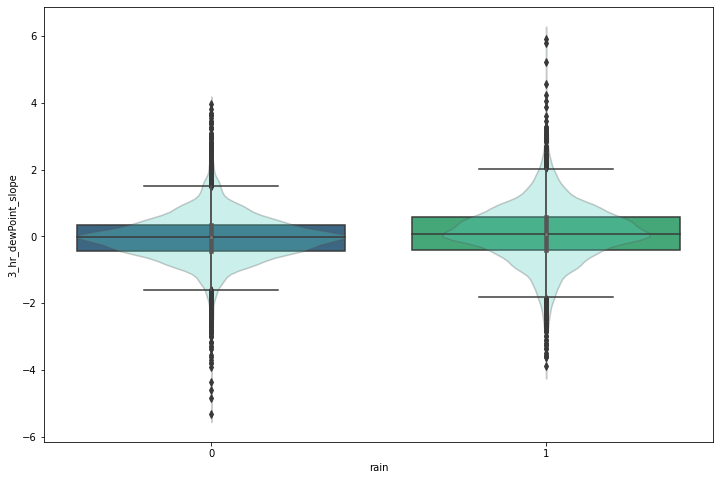

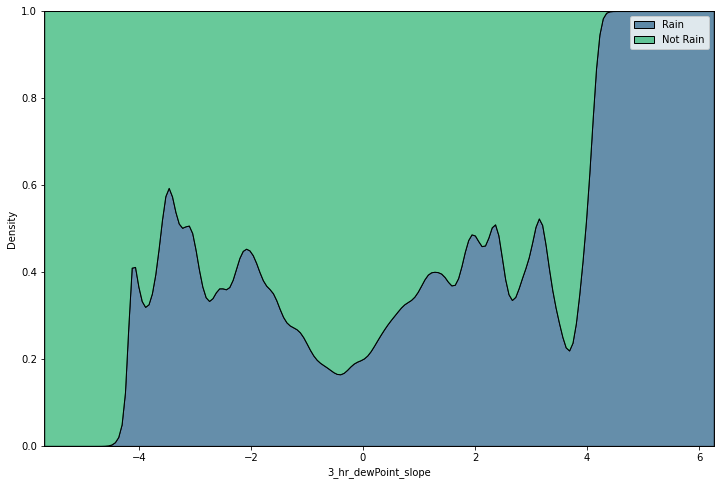

Pearson correlation of 12_hr_dewPoint_slope to target rain: 0.15202525924157978


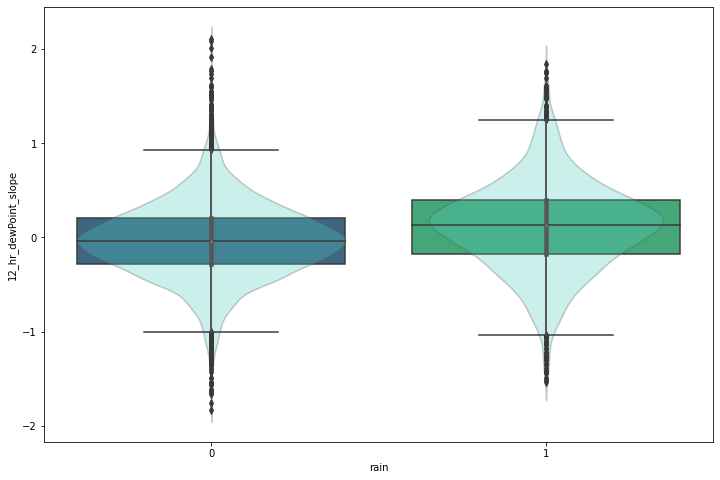

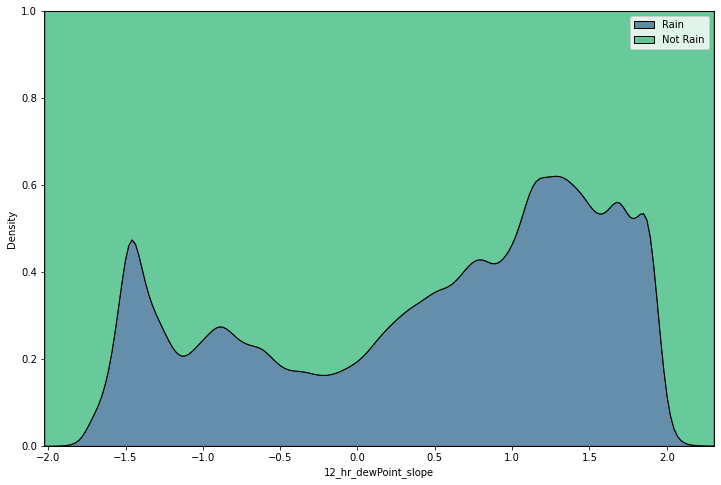

Pearson correlation of 3_hr_humidity_slope to target rain: 0.09298667357434601


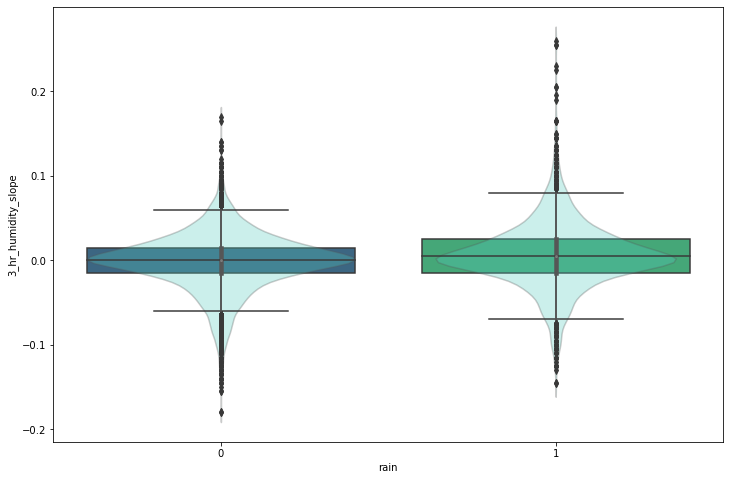

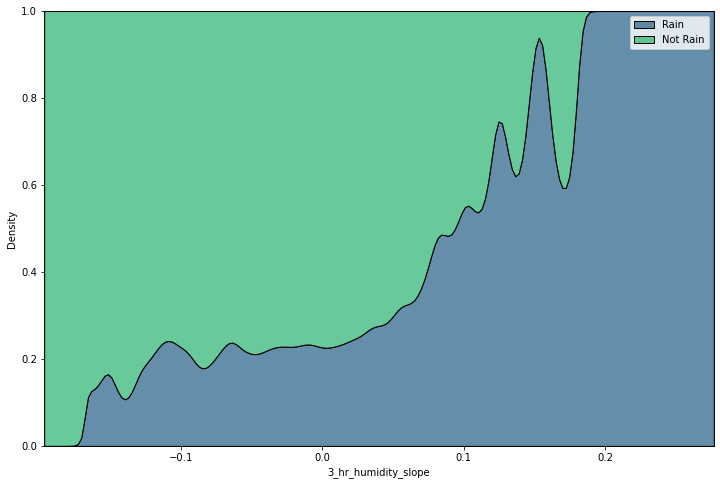

Pearson correlation of 12_hr_humidity_slope to target rain: 0.05985303508200892


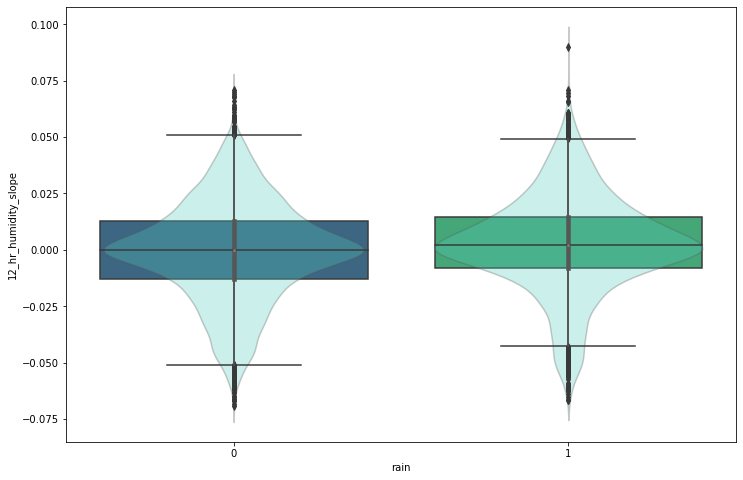

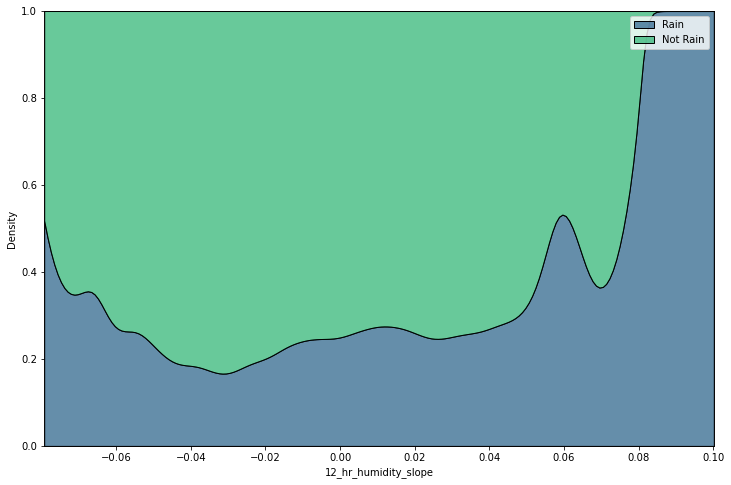

Pearson correlation of 3_hr_windSpeed_slope to target rain: 0.007602448758980762


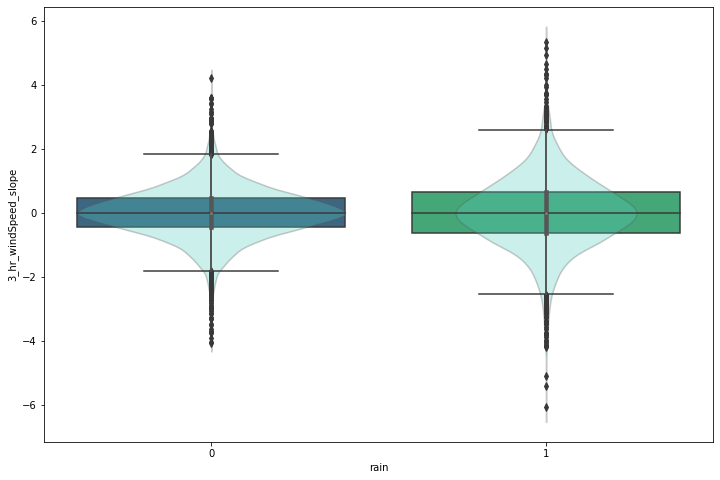

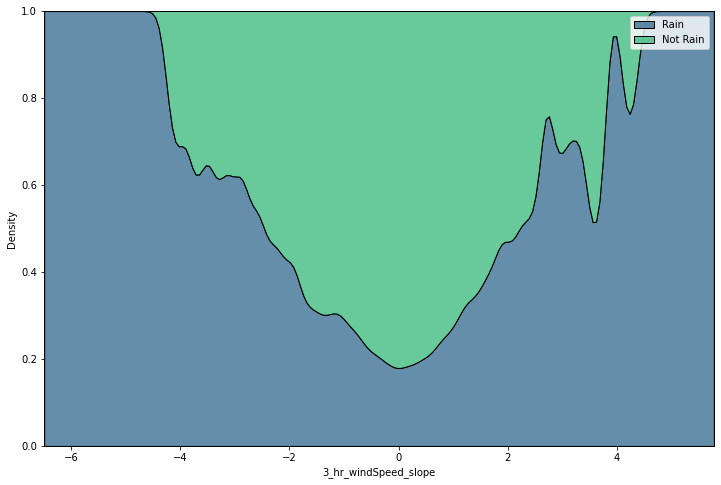

Pearson correlation of 12_hr_windSpeed_slope to target rain: 0.06945913488629671


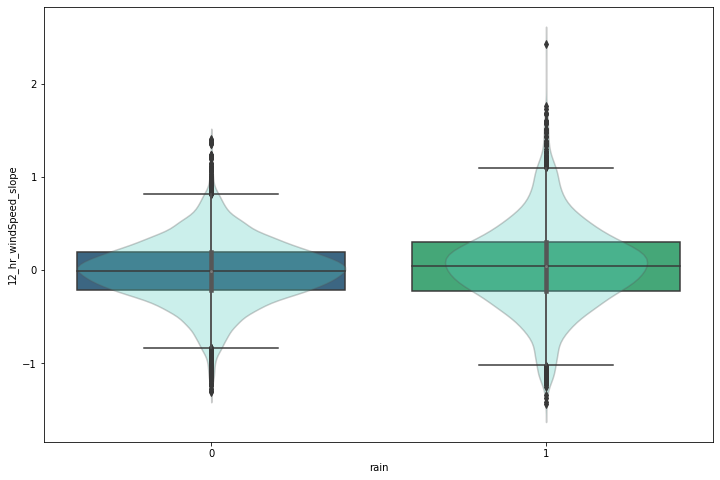

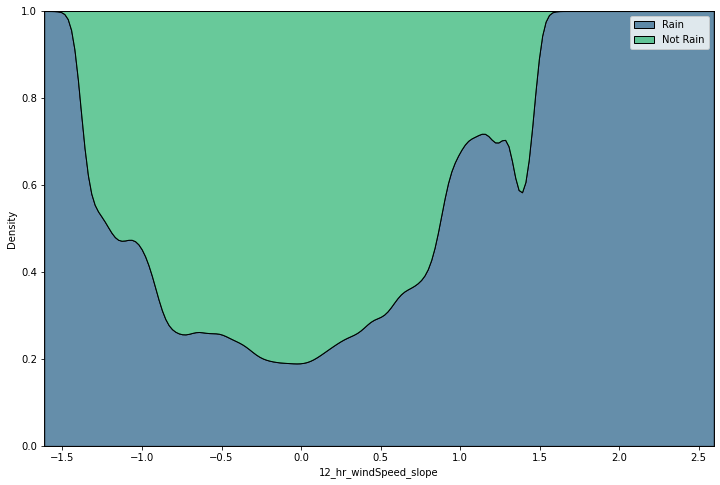

Pearson correlation of 3_hr_windGust_slope to target rain: 0.003222868946766542


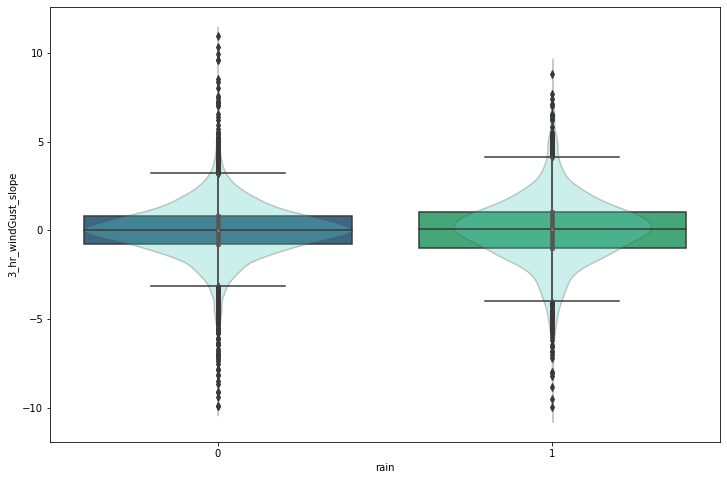

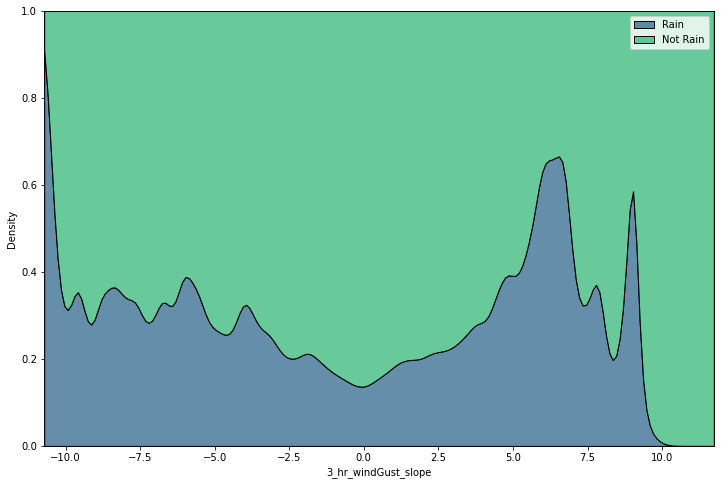

Pearson correlation of 12_hr_windGust_slope to target rain: 0.08371576980861369


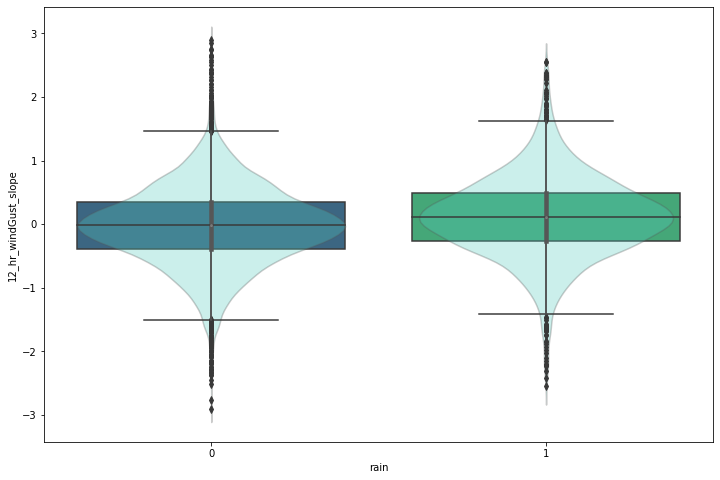

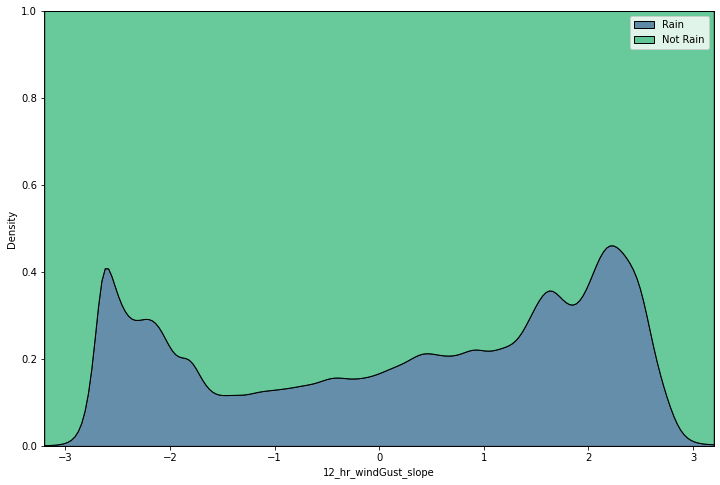

Pearson correlation of 3_hr_visibility_slope to target rain: -0.011627308914703557


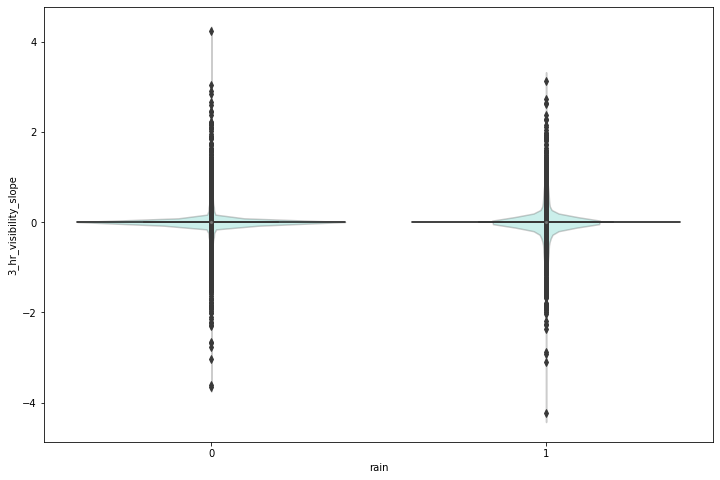

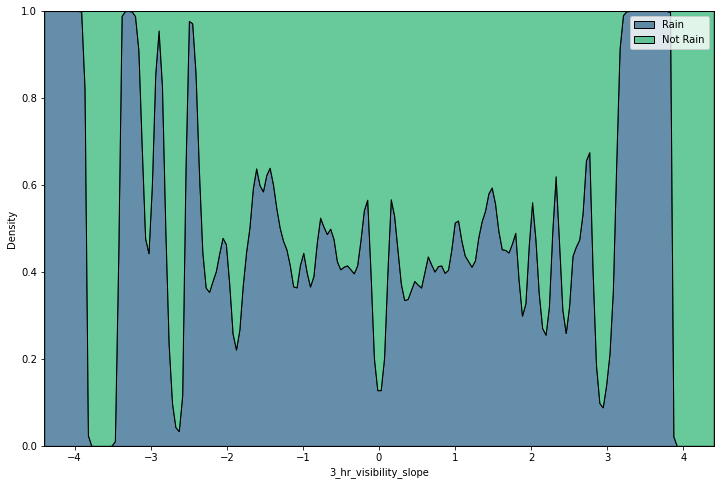

Pearson correlation of 12_hr_visibility_slope to target rain: -0.06614046642466324


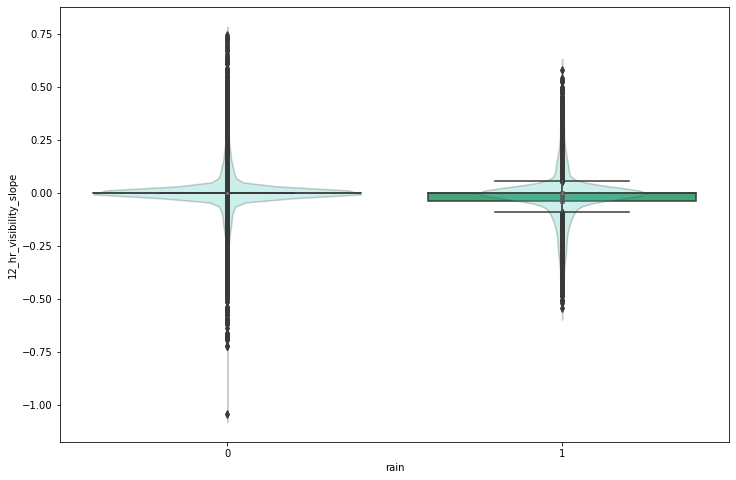

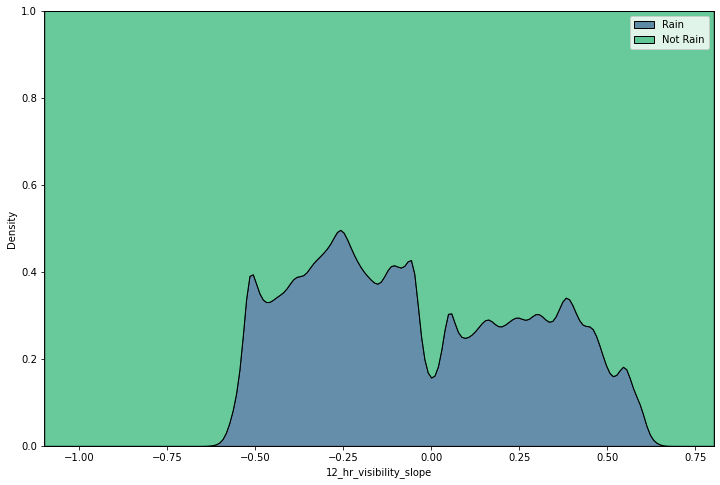

Pearson correlation of 3_hr_pressure_slope to target rain: -0.024441301684774534


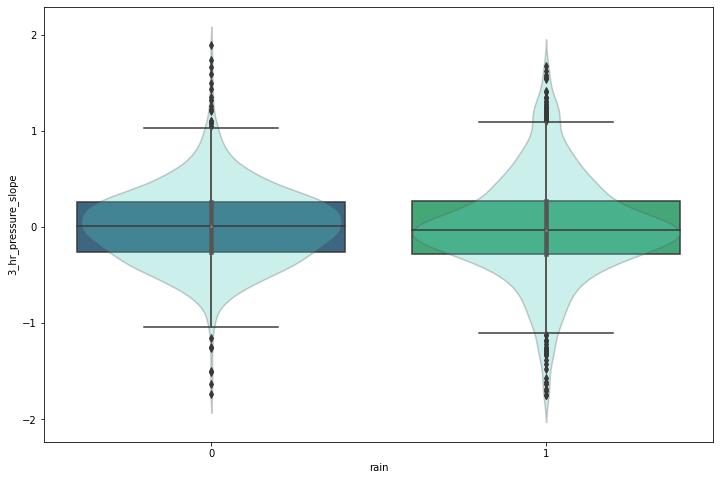

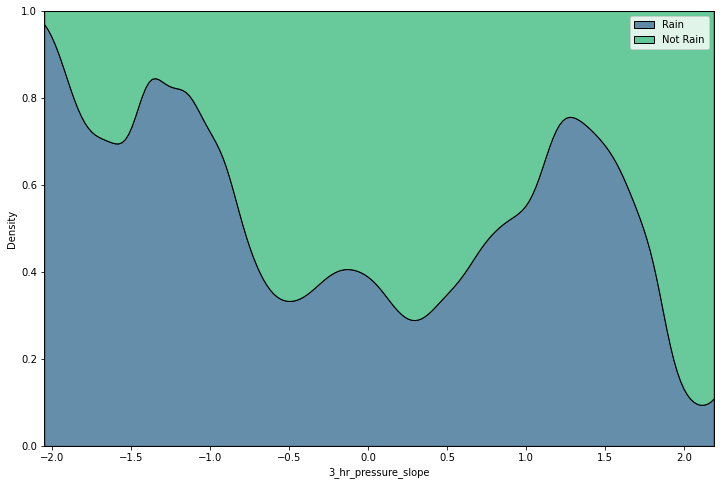

Pearson correlation of 12_hr_pressure_slope to target rain: -0.13175696842180956


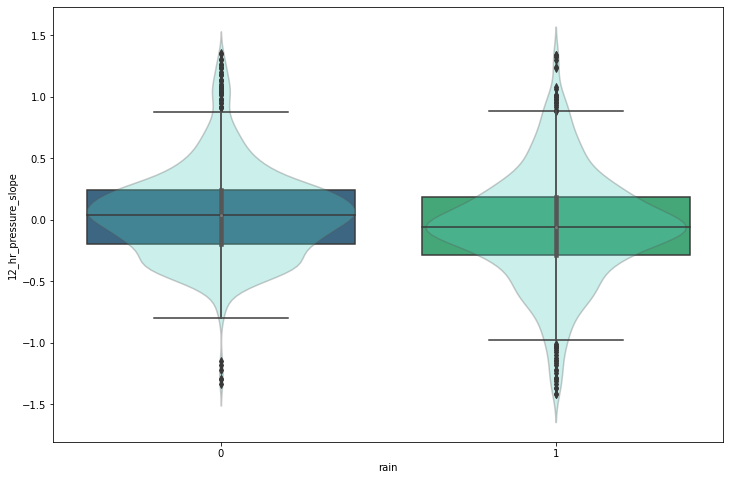

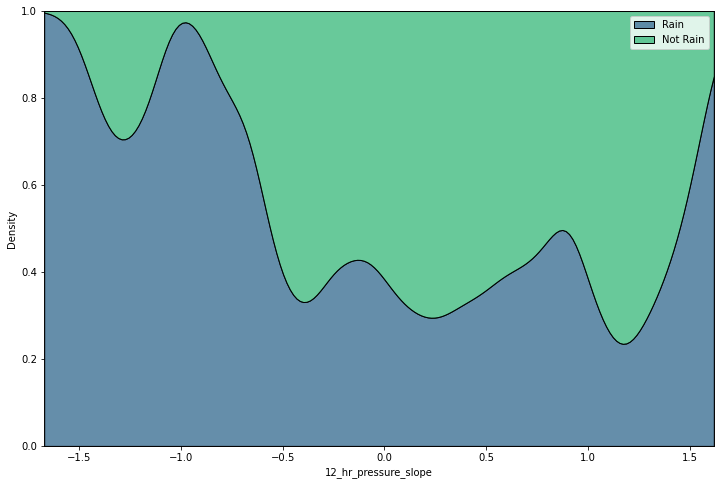

Pearson correlation of 3_hr_ozone_slope to target rain: 0.07758789707609805


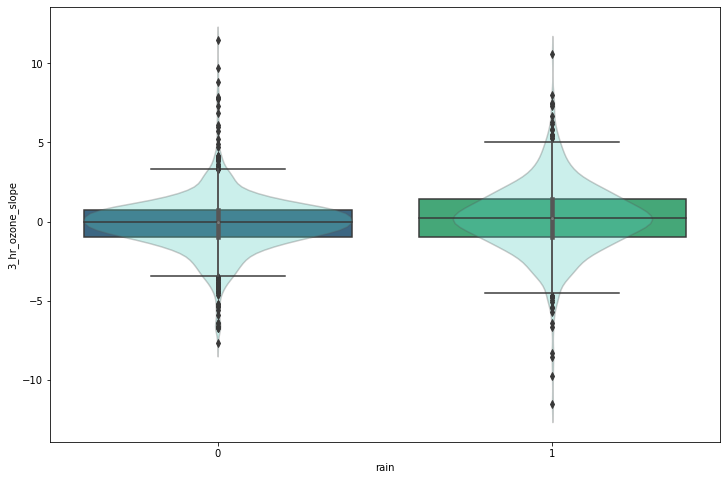

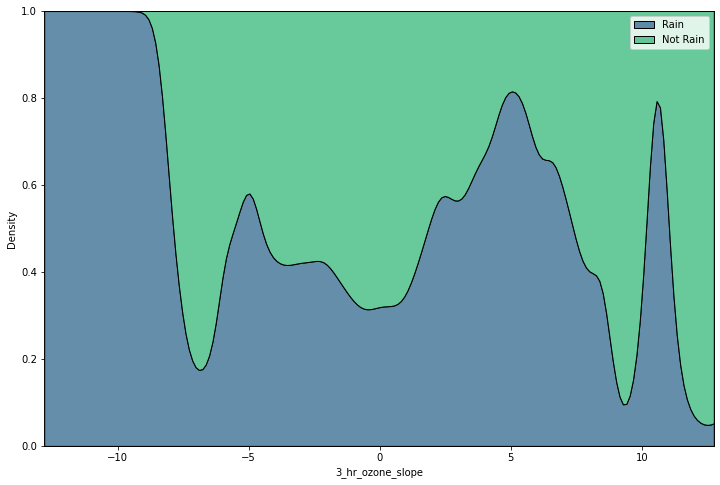

Pearson correlation of 12_hr_ozone_slope to target rain: 0.07583451447262106


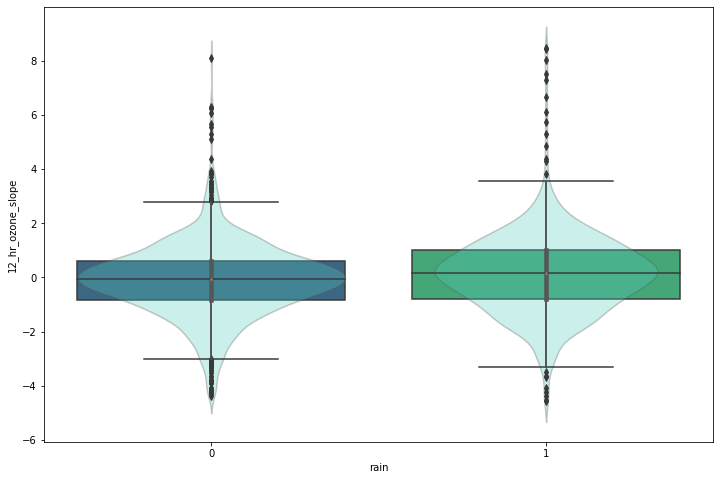

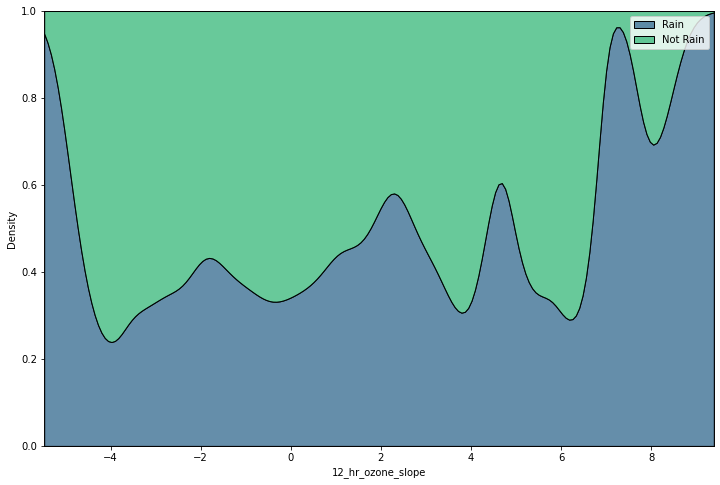

In [459]:
slope_vars  = ["{}_{}_slope".format(hour, col) for col in rolling_vars for hour in ["3_hr", "12_hr"]]
for col in slope_vars:
    print("Pearson correlation of {} to target rain: {}".format(col, df[col].corr(df.rain)))
    univariate_swarm_boxplot(df, 'rain', col)
    univariate_cdplot(df, 'rain', col)

In [427]:
df.corr()['rain'][slope_vars].sort_values()

12_hr_pressure_slope              -0.131757
12_hr_visibility_slope            -0.066140
3_hr_apparentTemperature_slope    -0.037339
3_hr_temperature_slope            -0.037265
3_hr_pressure_slope               -0.024441
3_hr_visibility_slope             -0.011627
3_hr_windGust_slope                0.003223
3_hr_windSpeed_slope               0.007602
12_hr_apparentTemperature_slope    0.015292
12_hr_temperature_slope            0.017460
12_hr_humidity_slope               0.059853
12_hr_windSpeed_slope              0.069459
12_hr_ozone_slope                  0.075835
3_hr_ozone_slope                   0.077588
12_hr_windGust_slope               0.083716
3_hr_dewPoint_slope                0.088121
3_hr_humidity_slope                0.092987
3_hr_precipIntensity_slope         0.110925
12_hr_dewPoint_slope               0.152025
12_hr_precipIntensity_slope        0.195150
3_hr_precipProbability_slope       0.227822
12_hr_precipProbability_slope      0.296752
Name: rain, dtype: float64

In [370]:
df.corr()['rain'][slope_vars].sort_values()

12_hr_pressure_slope              -0.131757
12_hr_visibility_slope            -0.066140
3_hr_apparentTemperature_slope    -0.037339
3_hr_temperature_slope            -0.037265
3_hr_pressure_slope               -0.024441
3_hr_visibility_slope             -0.011627
3_hr_windGust_slope                0.003223
3_hr_windSpeed_slope               0.007602
12_hr_apparentTemperature_slope    0.015292
12_hr_temperature_slope            0.017460
12_hr_humidity_slope               0.059853
12_hr_windSpeed_slope              0.069459
12_hr_ozone_slope                  0.075835
3_hr_ozone_slope                   0.077588
3_hr_precipIntensity_slope         0.081565
12_hr_windGust_slope               0.083716
3_hr_dewPoint_slope                0.088121
3_hr_humidity_slope                0.092987
12_hr_dewPoint_slope               0.152025
12_hr_precipIntensity_slope        0.224316
3_hr_precipProbability_slope       0.227822
12_hr_precipProbability_slope      0.296752
Name: rain, dtype: float64

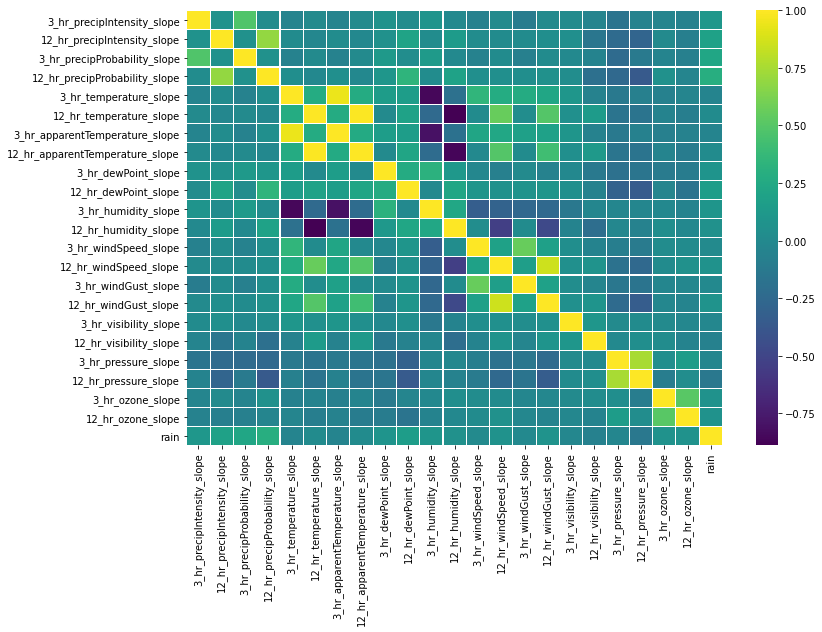

In [428]:
plt.figure(figsize = (12,8))
sns.heatmap(df[slope_vars + ["rain"]].corr(), linewidths = 0.1, cmap = "viridis")
# params not used annot = True, fmt=".2"
plt.show()

all of these features have a good correlation with the target and aren't too colinear after filtering out/ removing the 6 hour slope features, with the caveat that for the precipProbability_slope I am not using the current probability in the slope calculation to prevent leakage

also, removing usage of apparent_temperature features in modeling since they are too linear with temperature

### Categorical Features

In [188]:
def univariate_barplot(df, feat1, feat2):
    plt.figure(figsize = (12,8))
    sns.barplot(y = df[feat1], x = df[feat2], palette = "viridis", orient = "h")
    plt.show()

In [189]:
categorical_cols = ['summary', 'icon']

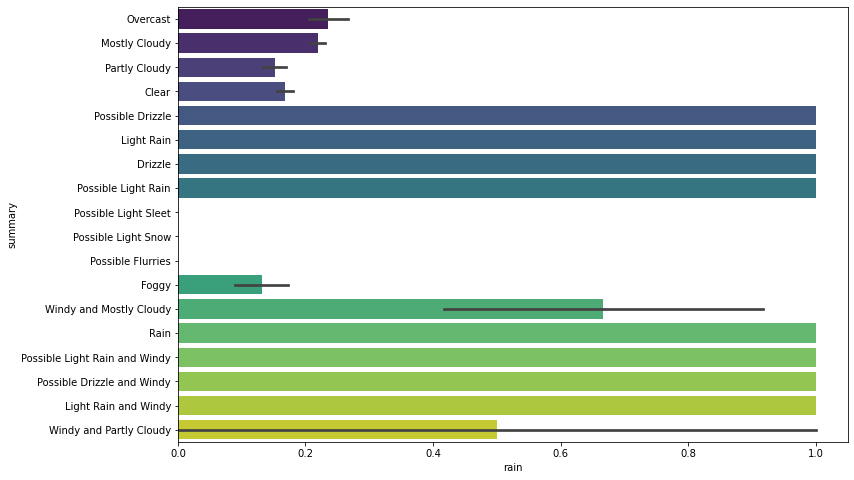

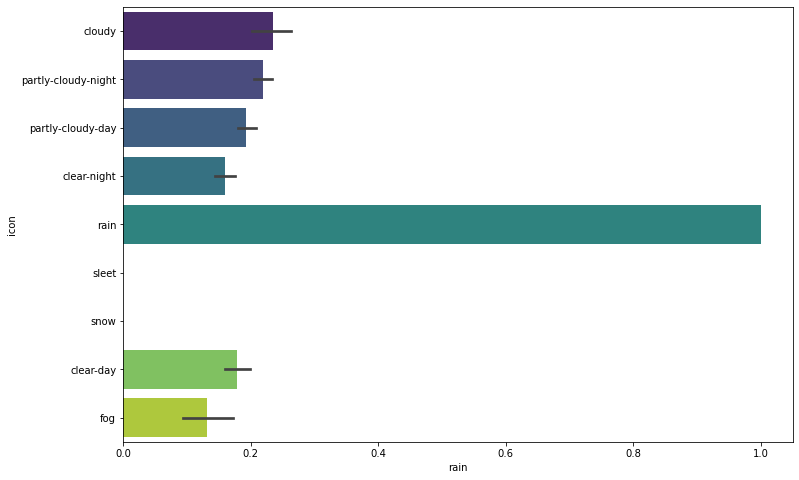

In [190]:
for col in categorical_cols:
    univariate_barplot(df, col, "rain")

Both these categorical variables have target leakage, not using

### Feature Selection Conclusions:
I am deciding to use the following continuous variables (untransformed)
'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex',
'visibility', 'month' as well as 'raining_last_hour'
and 3 hour/12 hour rate of change slopes for 'precipIntensity', 'precipProbability','temperature', 'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed', 'windGust', 'visibility', 'pressure' , 'ozone'

# Modeling
### train test holdout set
we may not want out of time test set, out of time holdout set since rain is so seasonal and we only have 18 months of data. a random split will be more robust since the model wont do we if we randomly pull a few months for test and validation. If we had several years worth of data, it would make more sense to have out of time test/holdout sets

In [466]:
def create_model_features(df, slope_vars):
    cols = ['temperature', 'dewPoint', 'humidity',
            'windSpeed', 'windGust', 'windBearing', 'cloudCover',
            'uvIndex', 'visibility', 'hour','month','raining_last_hour',
            'pressure', 'ozone', 'rain']
    sv = slope_vars
    sv.remove('3_hr_apparentTemperature_slope')
    sv.remove('12_hr_apparentTemperature_slope')
    sv
    model_cols = cols + slope_vars
    return df[model_cols].copy()
    
def get_train_test_holdout(model_df):
    X = model_df.drop(columns = ["rain"])
    y = model_df.rain.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 30 )
    # for holdout set take piece of train 0.125 x 0.8 = 0.1 of whole set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state= 30 ) 
    target_weight = (len(y_train) - y_train.sum()) / y_train.sum()
    
    return X_train, y_train, X_test, y_test, X_val, y_val, target_weight
    
def model_summary(model, X_train, y_train, X_test, y_test, threshold = 0.5):
    # train set predictions
    train_pred_prob = model.predict_proba(X_train)[:,1]
    train_pred = (train_pred_prob > threshold).astype("int")
    # test set predictions
    test_pred_prob = model.predict_proba(X_test)[:,1]
    test_pred = (test_pred_prob > threshold).astype("int")
    # model report
    print("Confusion Matrix for Test Set")
    print(confusion_matrix(y_test, test_pred))
    
    print("\n Classification Report for Test Set")
    print(classification_report(y_test, test_pred))
    
    print("Accuracy Train: {:.4f}".format(accuracy_score(y_train, train_pred)))
    print("AUC Train: {}".format(roc_auc_score(y_train, train_pred)))
    print("Accuracy Test: {:.4f}".format(accuracy_score(y_test, test_pred)))
    print("AUC Test: {}".format(roc_auc_score(y_test, test_pred)))
    
def plot_roc_curve(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred_pred = model.predict(X_test)
    test_auc = roc_auc_score(y_test, y_pred_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label = "AUC = {:.3f}".format(test_auc))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.title("ROC Plot")
    plt.legend(loc = "lower right")
    plt.show()

In [448]:
model_df = create_model_features(df, slope_vars)
X_train, y_train, X_test, y_test, X_val, y_val, target_weight = get_train_test_holdout(model_df)

## XGBoost

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[00:46:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Simple XGBoost Result
Confusion Matrix for Test Set
[[1769   69]
 [  67  490]]

 Classification Report for Test Set
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1838
           1       0.88      0.88      0.88       557

    accuracy                           0.94      2395
   macro avg       0.92      0.92      0.92      2395
weighted avg       0.94      0.94      0.94      2395

Accuracy Train: 1.0000
AUC Train: 1.0
Accuracy Test: 0.9432
AUC Test: 0.9210859708175501


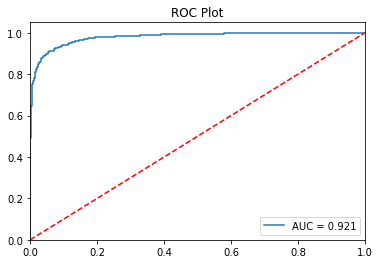

In [467]:
# baseline XGB
seed = 30
simple_xgb = xgb.XGBClassifier(random_state = seed, scale_pos_weight = target_weight)
simple_xgb.fit(X_train, y_train)
simple_xgb_pred_prob = simple_xgb.predict_proba(X_test)[:,1]
simple_xgb_pred = simple_xgb.predict(X_test)

print("Simple XGBoost Result")
model_summary(simple_xgb, X_train, y_train, X_test, y_test)
plot_roc_curve(simple_xgb, X_test, y_test)

Confusion Matrix for Test Set
[[870  47]
 [ 41 240]]

 Classification Report for Test Set
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       917
           1       0.84      0.85      0.85       281

    accuracy                           0.93      1198
   macro avg       0.90      0.90      0.90      1198
weighted avg       0.93      0.93      0.93      1198

Accuracy Train: 1.0000
AUC Train: 1.0
Accuracy Test: 0.9265
AUC Test: 0.9014192186341815


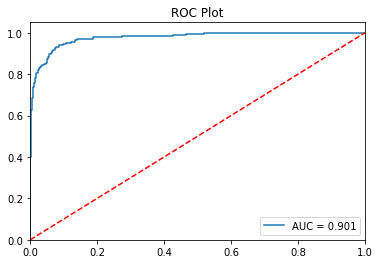

In [468]:
# holdout set results
model_summary(simple_xgb, X_train, y_train, X_val, y_val)
plot_roc_curve(simple_xgb, X_val, y_val)

In [451]:
# shap results for model
mybooster = simple_xgb.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfunc(self = None):
    return model_bytearray
mybooster.save_raw = myfunc

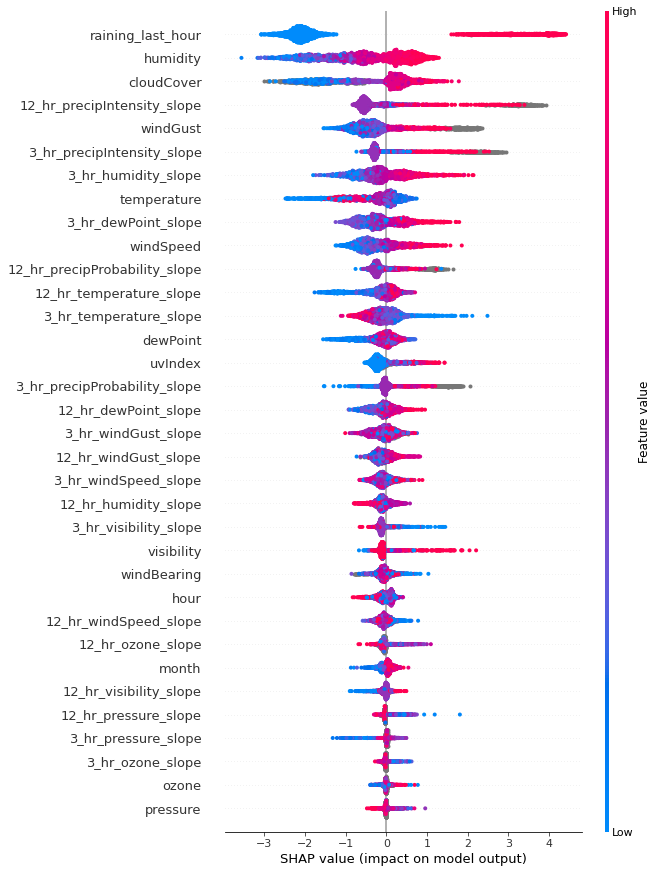

In [469]:
explainer = shap.TreeExplainer(mybooster)
simple_shap_values = explainer.shap_values(X_test)
shap.summary_plot(simple_shap_values, X_test, max_display = X_test.columns.nunique())

Based on Reviewing these findings along with the super high AUC, I am going to retrain the model shifting the 3 hour and 12 hour precipitation slopes to not include the current hour of the pertaining row as to prevent leakage. However, I do not see any reason to remove the binary flag if it was raining the prior hour; that is not leakage. 